### Library imports

In [1]:
# General module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from math import sqrt
import collections
import gym

import random
import time
import argparse
import os

# Imports to normalize and study the data
from sklearn.metrics import (confusion_matrix, accuracy_score, classification_report, roc_curve, auc)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy.stats as st
from tensorflow import reduce_mean, square, math

# Functions to create the network
#import tensorlayer as tl
from numpy import array
import tensorflow as tf
from tensorlayer.layers import Dense
from tensorlayer.models import Model

import tensorflow_probability as tfp
Normal = tfp.distributions.Normal

# TRAIN PART

### Create and train model

In [2]:
def load_dataset():
    # reading csv file
    path = 'data/'
    archivo1 = 'CC2_BAC1_2020_Load_100.csv'
    archivo2 = 'CC2_BAC1_2021_Load_100.csv'
    archivo3 = 'CC2_BAC1_2022_Load_100.csv'
    archivo11 = 'CC2_BAC1_2020_Load_50.csv'
    archivo21 = 'CC2_BAC1_2021_Load_50.csv'
    archivo31 = 'CC2_BAC1_2022_Load_50.csv'

    df1 = pd.read_csv(path+ archivo1, delimiter = ',', encoding='latin-1')
    df2 = pd.read_csv(path+ archivo2, delimiter = ',', encoding='latin-1')
    df3 = pd.read_csv(path+ archivo3, delimiter = ',', encoding='latin-1')
    df1a = pd.read_csv(path+ archivo11, delimiter = ',', encoding='latin-1')
    df2a = pd.read_csv(path+ archivo21, delimiter = ',', encoding='latin-1')
    df3a = pd.read_csv(path+ archivo31, delimiter = ',', encoding='latin-1')


    df11=df1.dropna() 
    df21=df2.dropna() 
    df31=df3.dropna()
    df12=df1a.dropna() 
    df22=df2a.dropna() 
    df32=df3a.dropna()
    df1 = pd.concat([df11, df12]).sort_values('FECHAS', ascending=True) 
    df2 = pd.concat([df21, df22]).sort_values('FECHAS', ascending=True) 
    df3 = pd.concat([df31, df32]).sort_values('FECHAS', ascending=True) 

    # Recuperation of the useful variables
    df1_scale = df1.iloc[:, [1,2,3,4,5,6,9,12,13,14]]
    datos1 = df1.iloc[:, [1,2,3,4,5,6,9,12,13,14]].query("Pot_Turb_Vapor__CC1 >= 5 and Pot_Turb_Vapor__CC2 >= 5 and Pot_Turb_Gas_5__CC2 >= 5 and Pot_Turb_Gas_6__CC2 >= 5")
    #datos1 = df1.query("FECHAS > '2020-09-01 00:00:00'").iloc[:, [1,2,3,4,5,6,9,12,13,14]].query("Pot_Turb_Vapor__CC1 >= 5 and Pot_Turb_Vapor__CC2 >= 5 and Pot_Turb_Gas_5__CC2 >= 5 and Pot_Turb_Gas_6__CC2 >= 5")
    
    # normalization features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df1_scale)
    datos1_scaled = scaler.transform(datos1)
  
    X_train, X_test, y_train, y_test = train_test_split(
                                        datos1_scaled[:,5:7],  # temperatura fase R y potencias turbinas
                                        datos1_scaled[:,[0]],           # vibracion cojinetes EMP
                                        random_state = 123,
                                        shuffle      = True)
    print("train: ",X_train.shape, y_train.shape, "\ntest: ", X_test.shape, y_test.shape,"\n")

    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = load_dataset() 
print("train: ",X_train.shape, y_train.shape, "\ntest: ", X_test.shape, y_test.shape,"\n")

train:  (12260, 2) (12260, 1) 
test:  (4087, 2) (4087, 1) 

train:  (12260, 2) (12260, 1) 
test:  (4087, 2) (4087, 1) 


In [4]:
#####################  hyper parameters  ####################
# choose env
RANDOM_SEED = 2                    # random seed
RENDER = True                      # render while training

# RL training
TRAIN_EPISODES = 100               # total number of episodes for training
MAX_STEPS = 100                    # maximum number of steps for one episode
EXPLORE_NOISE_SCALE = 0.1          # range of action noise for exploration
EVAL_NOISE_SCALE = 0.5*0.5         # range of action noise for evaluation of action value

REPLAY_BUFFER_SIZE = 1032          # size of replay buffer
BATCH_SIZE = 1024                  # update batch size

HIDDEN_DIM = 64                    # size of hidden layers for networks
Q_LR = 3e-4                        # q_net learning rate
POLICY_LR = 3e-4                   # policy_net learning rate
UPDATE_ITR = 3                     # repeated updates for single step
POLICY_TARGET_UPDATE_INTERVAL = 10 # delayed steps for updating the policy network and target networks 

REWARD_SCALE = 100.                # value range of reward
GAMMA = 0.1                        # value range of prediction weight in training


In [5]:
class ReplayBuffer:
    """
    a ring buffer for storing transitions and sampling for training
    :state: (state_dim,)
    :action: (action_dim,)
    :reward: (,), scalar
    :next_state: (state_dim,)
    :done: (,), scalar (0 and 1) or bool (True and False)
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, action_init, reward, next_state, expected_action, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, action_init, reward, next_state, expected_action, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, action_init, reward, next_state, expected_action, done = map(np.stack, zip(*batch))  # stack for each element
        """ 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        """
        return state, action, action_init, reward, next_state, expected_action, done
    
    def slices(self, batch_size):
        if self.position-batch_size <0:
            batch = self.buffer[self.position-batch_size:]+self.buffer[:self.position]
        else:
            batch = self.buffer[self.position-batch_size:self.position] #random.sample(self.buffer, batch_size)
        state, action, action_init, reward, next_state, expected_action, done = map(np.stack, zip(*batch))  # stack for each element
        """ 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        """
        return state, action, action_init, reward, next_state, expected_action, done

    def __len__(self):
        return len(self.buffer)

In [6]:
# define model
class QNetwork(Model):
    """ the network for evaluate values of state-action pairs: Q(s,a) """

    def __init__(self, num_inputs, num_actions, hidden_dim, init_w=3):
        super(QNetwork, self).__init__()
        input_dim = num_inputs + num_actions
        # w_init = tf.keras.initializers.glorot_normal(seed=None)
        w_init = tf.random_uniform_initializer(-init_w, init_w)

        self.linear1 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=input_dim, name='q1')
        self.linear2 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim, name='q2')
        self.linear3 = Dense(n_units=1, W_init=w_init, in_channels=hidden_dim, name='q3')

    def forward(self, input):
        x = self.linear1(input)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [7]:
class PolicyNetwork(Model):
    """ the network for generating non-determinstic (Gaussian distributed) action from the state input """

    def __init__(self, num_inputs, num_actions, hidden_dim, action_range=1., init_w=3e-1):
        super(PolicyNetwork, self).__init__()
        w_init = tf.random_uniform_initializer(-init_w, init_w)

        self.linear1 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=num_inputs, name='policy1')
        self.linear2 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim, name='policy2')
        self.linear3 = Dense(n_units=hidden_dim, act=tf.nn.relu, W_init=w_init, in_channels=hidden_dim, name='policy3')
        self.output_linear = Dense(
            n_units=num_actions, W_init=w_init, b_init=tf.random_uniform_initializer(-init_w, init_w),
            in_channels=hidden_dim, name='policy_output'
        )
        self.action_range = action_range
        self.num_actions = num_actions

    def forward(self, state):            
        x = self.linear1(state)
        x = self.linear2(x)
        x = self.linear3(x)
        output = tf.nn.relu(self.output_linear(x))  # unit range output [0, 1]
        return output

    def evaluate(self, state, eval_noise_scale):
        """ 
        generate action with state for calculating gradients;
        eval_noise_scale: as the trick of target policy smoothing, for generating noisy actions.
        """
        state = state.astype(np.float32)
        action = self.forward(state)
        action = self.action_range * action

        # add noise
        normal = Normal(0, 1)
        eval_noise_clip = 2 * eval_noise_scale
        noise = normal.sample(action.shape) * eval_noise_scale
        noise = tf.clip_by_value(noise, -eval_noise_clip, eval_noise_clip)
        action = action + noise
        return action

    def get_action(self, state, explore_noise_scale, greedy=False):
        """ generate action with state for interaction with environment """
        action_init = self.forward([state])
        action = action_init
        action = self.action_range * action.numpy()[0]
        action_init = self.action_range * action_init.numpy()[0]
        if greedy:
            return action.tolist(), action_init.tolist()
        # add noise
        normal = Normal(0, 1)
        noise = normal.sample(action.shape) * explore_noise_scale
        action += noise
        return action.numpy(), action_init.tolist()

    def sample_action(self):
        """ generate random actions for exploration """
        a = tf.random.uniform([self.num_actions], 0, 1)
        return self.action_range * a.numpy()

In [8]:
class TD3:

    def __init__(
            self, state_dim, action_dim, action_range, hidden_dim, replay_buffer, policy_target_update_interval,
            q_lr=Q_LR, policy_lr=POLICY_LR
    ):
        self.replay_buffer = replay_buffer

        # initialize all networks
        self.q_net1 = QNetwork(state_dim, action_dim, hidden_dim)
        self.q_net2 = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_q_net1 = QNetwork(state_dim, action_dim, hidden_dim)
        self.target_q_net2 = QNetwork(state_dim, action_dim, hidden_dim)
        self.policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, action_range)
        self.target_policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim, action_range)
        print('Q Network (1,2): ', self.q_net1)
        print('Policy Network: ', self.policy_net)

        # initialize weights of target networks
        self.target_q_net1 = self.target_ini(self.q_net1, self.target_q_net1)
        self.target_q_net2 = self.target_ini(self.q_net2, self.target_q_net2)
        self.target_policy_net = self.target_ini(self.policy_net, self.target_policy_net)

        # set train mode
        self.q_net1.train()
        self.q_net2.train()
        self.target_q_net1.eval()
        self.target_q_net2.eval()
        self.policy_net.train()
        self.target_policy_net.eval()

        self.update_cnt = 0
        self.policy_target_update_interval = policy_target_update_interval

        self.q_optimizer1 = tf.optimizers.Adam(q_lr)
        self.q_optimizer2 = tf.optimizers.Adam(q_lr)
        self.policy_optimizer = tf.optimizers.Adam(policy_lr)

    def get_prediction(self, X):
        self.policy_net.eval()
        pred = self.policy_net(X.astype('float32'))
        self.policy_net.train()
        return(pred)

    def target_ini(self, net, target_net):
        """ hard-copy update for initializing target networks """
        total_weight = 0
        for i in range(len(target_net.trainable_weights)):
            print(i,target_net.trainable_weights[i].shape)
            if len(target_net.trainable_weights[i].shape) == 2:
                total_weight += target_net.trainable_weights[i].shape[0]*target_net.trainable_weights[i].shape[1]
            elif len(target_net.trainable_weights[i].shape) == 1:
                total_weight += target_net.trainable_weights[i].shape[0]
        print('nb_weight', total_weight)
            
        for target_param, param in zip(target_net.trainable_weights, net.trainable_weights):
            target_param.assign(param)
        return target_net

    def target_soft_update(self, net, target_net, soft_tau):
        """ soft update the target net with Polyak averaging """
        for target_param, param in zip(target_net.trainable_weights, net.trainable_weights):
            target_param.assign(  # copy weight value into target parameters
                target_param * (1.0 - soft_tau) + param * soft_tau
            )
        return target_net

    def update(self, batch_size, eval_noise_scale, reward_scale=10., gamma=GAMMA, soft_tau=1e-1): # soft_tau=1e-2 gamma 0.2/0.1
        """ update all networks in TD3 """
        return_info = []
        self.update_cnt += 1
        state, action, _, reward, next_state, expected_action, done = self.replay_buffer.sample(batch_size)

        reward = reward[:, np.newaxis]  # expand dim
        done = done[:, np.newaxis]

        new_next_action = self.target_policy_net.evaluate(
            next_state, eval_noise_scale=eval_noise_scale
        )  # clipped normal noise
        reward = reward_scale * (reward - np.mean(reward, axis=0)) / (
            np.std(reward, axis=0) + 1e-6
        )  # normalize with batch mean and std; plus a small number to prevent numerical problem

        # Training Q Function
        target_q_input = tf.concat([next_state, new_next_action], 1)  # the dim 0 is number of samples
        target_q_min = tf.minimum(self.target_q_net1(target_q_input), self.target_q_net2(target_q_input))
        
        target_q_value = reward + (1 - done) * gamma * target_q_min  # if done==1, only reward
        q_input = tf.concat([state, action], 1)  # input of q_net

        with tf.GradientTape() as q1_tape:
            predicted_q_value1 = self.q_net1(q_input)
            q_value_loss1 = tf.reduce_mean(tf.square(predicted_q_value1 - target_q_value))
            return_info.append(['q_value_loss1', q_value_loss1.numpy()])
        q1_grad = q1_tape.gradient(q_value_loss1, self.q_net1.trainable_weights)
        self.q_optimizer1.apply_gradients(zip(q1_grad, self.q_net1.trainable_weights))
        
        with tf.GradientTape() as q2_tape:
            predicted_q_value2 = self.q_net2(q_input)
            q_value_loss2 = tf.reduce_mean(tf.square(predicted_q_value2 - target_q_value))
            return_info.append(['q_value_loss2', q_value_loss2.numpy()])
        q2_grad = q2_tape.gradient(q_value_loss2, self.q_net2.trainable_weights)
        self.q_optimizer2.apply_gradients(zip(q2_grad, self.q_net2.trainable_weights))
        
        # Training Policy Function
        if self.update_cnt % self.policy_target_update_interval == 0: # and self.update_cnt>1000:
            with tf.GradientTape() as p_tape:
                new_action = self.policy_net.evaluate(
                    state, eval_noise_scale=0.0
                )  # no noise, deterministic policy gradients
                new_q_input = tf.concat([state, new_action], 1)
                # """ implementation 1 """
                predicted_new_q_value = tf.minimum(self.q_net1(new_q_input),self.q_net2(new_q_input)) #new_q_input
                # """ implementation 2 """
                # predicted_new_q_value = self.q_net1(new_q_input)
                policy_loss = -tf.reduce_mean(predicted_new_q_value)
                return_info.append(['policy_loss', policy_loss.numpy()])
            p_grad = p_tape.gradient(policy_loss, self.policy_net.trainable_weights)
            self.policy_optimizer.apply_gradients(zip(p_grad, self.policy_net.trainable_weights))
            
            # Soft update the target nets
            self.target_policy_net = self.target_soft_update(self.policy_net, self.target_policy_net, soft_tau)
            self.target_q_net1 = self.target_soft_update(self.q_net1, self.target_q_net1, soft_tau)
            self.target_q_net2 = self.target_soft_update(self.q_net2, self.target_q_net2, soft_tau)
            
        return return_info
    
    def save(self):  # save trained weights
        #models_dir = 'models_RL/'
        models_dir = 'models/'
        existing_models = [filename for filename in os.listdir(models_dir) if filename.startswith('model_policy_netA')]
        num_model = len(existing_models)+1
            
        path = os.path.join(models_dir)
        if not os.path.exists(path):
            os.makedirs(path)
        extend_path = lambda s: os.path.join(path, s)
        #tl.files.save_npz(self.q_net1.trainable_weights, extend_path(f'model_q_net1_{num_model}.npz'))
        #tl.files.save_npz(self.q_net2.trainable_weights, extend_path(f'model_q_net2_{num_model}.npz'))
        #tl.files.save_npz(self.target_q_net1.trainable_weights, extend_path(f'model_target_q_net1_{num_model}.npz'))
        #tl.files.save_npz(self.target_q_net2.trainable_weights, extend_path(f'model_target_q_net2_{num_model}.npz'))
        tl.files.save_npz(self.policy_net.trainable_weights, extend_path(f'model_policy_net_{num_model}.npz'))
        #tl.files.save_npz(self.target_policy_net.trainable_weights, extend_path(f'model_target_policy_net_{num_model}.npz'))


In [9]:
class CojineteEnv(gym.Env):
    """
    Custom gym environment for classifying rotating machinery faults in a power plant.
    """
    def __init__(self, dataset):
        """
        Initializes the environment class.

        Input:
        - dataset: input features and labels
        """
        super().__init__()
        #self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(1, 5), dtype=np.float32) 
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(1, 2), dtype=np.float32) 
        self.action_space = gym.spaces.Box(low=0.0, high=1.0, shape=(1, 1), dtype=np.float32)
        self.x, self.y = dataset
        self.obs_idx = 0

    def step(self, action):
        """
        Executes one step in the environment. Receives an action from the agent, calculates the corresponding reward, 
        returns the new observation, the reward, a boolean flag indicating whether the episode has terminated, and any 
        additional information.

        Input:
        - action (int): an integer indicating the selected action (0 for healthy, 1 for inner ring fault, 
                        2 for outer ring fault).

        Output:
        - obs (numpy.ndarray): the new observation (i.e., input features for the selected example)
        - reward (float): the reward obtained from the action (1 for a correct classification, -1 for an incorrect 
                          classification).
        - done (bool): a boolean flag indicating whether the episode has terminated (which is always False)
        - info (dict): a dictionary containing any additional information (not used in this environment)
        """
        
        
        diferencia = abs(action-self.expected_action)
        if diferencia < 0.001 :
            reward = 1000
        elif diferencia < 0.005:
            reward = 300
        elif diferencia < 0.01:
            reward = 0
        elif diferencia < 0.05:
            reward = -150
        elif diferencia < 0.1:
            reward = -500
        elif diferencia < 0.3:
            reward = -1000
        else:                      
            reward = -1500
        
        expected_action = self.expected_action[0]
        obs = self._next_obs()

        return obs, reward, False, expected_action

    def _next_obs(self):
        """
        Returns the input features for a randomly selected example from the dataset. Also sets the expected action
        based on the label of the selected example.

        Output:
        - obs (numpy.ndarray): the input features for the selected example.
        """
        
        self.expected_action = self.y[self.obs_idx]
        obs = self.x[self.obs_idx]
        self.obs_idx = (self.obs_idx+1)%len(self.x)
        
        return obs
    
    def render(self, buffer):
        """
        Display the 100 last elements of the replay buffer.
        """
        state, action, action_init, reward, next_state, expected_action, done = buffer
        fig, ax = plt.subplots()  # Tamaño figura
        
        mean_real = 0
        mean_predicho = 0
        count = 0
        
        for act in action:
            mean_predicho += act
            count += 1
        mean_predicho /= count
        count = 0
        for act in expected_action:
            mean_real += act
            count += 1
        mean_real /= count
        print('mean_real, mean_predicho : ', mean_real, mean_predicho)
        
        plt.plot(expected_action, label='real', marker='+', linestyle='None')
        plt.plot(action, label='predicho', marker='+', linestyle='None')
        plt.plot(action_init, label='predicho_init', marker='+', linestyle='None')
        plt.title('Actions')
        plt.grid(True)
        plt.legend(loc='lower left')
        plt.show()
        
        plt.plot(reward, label='predicho', marker='+', linestyle='None')
        plt.title('Reward')
        plt.grid(True)
        plt.legend(loc='lower left')
        plt.show()
            
        

In [10]:
env = CojineteEnv(dataset=(X_train, y_train))

env.observation_space.shape[1]

2

In [11]:
# initialization of env
X_train, y_train, X_test, y_test = load_dataset() 
env = CojineteEnv(dataset=(X_train, y_train))
state_dim = env.observation_space.shape[1]
action_dim = env.action_space.shape[1]
action_range = env.action_space.high

# reproducible
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# initialization of buffer
replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
# initialization of trainer
agent = TD3(
    state_dim, action_dim, action_range, HIDDEN_DIM, replay_buffer, POLICY_TARGET_UPDATE_INTERVAL, Q_LR, POLICY_LR
)

train:  (12260, 2) (12260, 1) 
test:  (4087, 2) (4087, 1) 

[TL] Dense  q1: 64 relu
[TL] Dense  q2: 64 relu
[TL] Dense  q3: 1 No Activation
[TL] Dense  q1: 64 relu
[TL] Dense  q2: 64 relu
[TL] Dense  q3: 1 No Activation
[TL] Dense  q1: 64 relu
[TL] Dense  q2: 64 relu
[TL] Dense  q3: 1 No Activation
[TL] Dense  q1: 64 relu
[TL] Dense  q2: 64 relu
[TL] Dense  q3: 1 No Activation
[TL] Dense  policy1: 64 relu
[TL] Dense  policy2: 64 relu
[TL] Dense  policy3: 64 relu
[TL] Dense  policy_output: 1 No Activation
[TL] Dense  policy1: 64 relu
[TL] Dense  policy2: 64 relu
[TL] Dense  policy3: 64 relu
[TL] Dense  policy_output: 1 No Activation
Q Network (1,2):  qnetwork(
  (q1): Dense(n_units=64, relu, in_channels='3', name='q1')
  (q2): Dense(n_units=64, relu, in_channels='64', name='q2')
  (q3): Dense(n_units=1, No Activation, in_channels='64', name='q3')
)
Policy Network:  policynetwork(
  (policy1): Dense(n_units=64, relu, in_channels='2', name='policy1')
  (policy2): Dense(n_units=64, relu, i

In [12]:
state = tf.cast(env._next_obs(), dtype=tf.float32)
state

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9653844, 0.7334951], dtype=float32)>

Training  | Episode: 1/100  | Episode Reward: -115100.0000  | Running Time: 0.0130
Training  | Episode: 2/100  | Episode Reward: -107500.0000  | Running Time: 0.0121
Training  | Episode: 3/100  | Episode Reward: -119250.0000  | Running Time: 0.0146
Training  | Episode: 4/100  | Episode Reward: -113350.0000  | Running Time: 0.0137
Training  | Episode: 5/100  | Episode Reward: -115800.0000  | Running Time: 0.0145
Training  | Episode: 6/100  | Episode Reward: -115900.0000  | Running Time: 0.0116
Training  | Episode: 7/100  | Episode Reward: -112500.0000  | Running Time: 0.0120
Training  | Episode: 8/100  | Episode Reward: -109100.0000  | Running Time: 0.0146
Training  | Episode: 9/100  | Episode Reward: -121900.0000  | Running Time: 0.0138
Training  | Episode: 10/100  | Episode Reward: -118450.0000  | Running Time: 0.0136
mean_real, mean_predicho :  0.8350174065876657 [0.45649007]


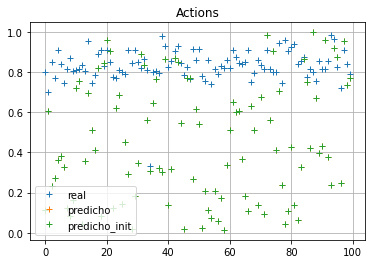

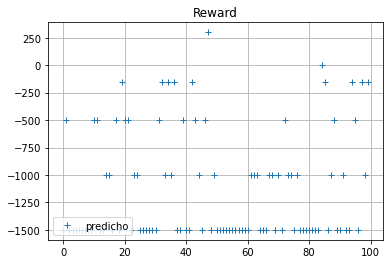

Training  | Episode: 11/100  | Episode Reward: -111550.0000  | Running Time: 6.3407
mean_real, mean_predicho :  0.8251277457293349 [0.50530124]


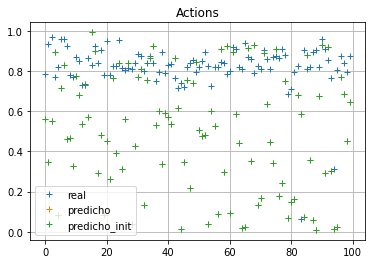

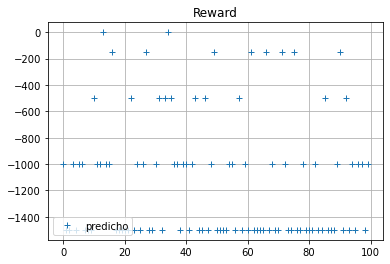

Training  | Episode: 12/100  | Episode Reward: -111700.0000  | Running Time: 8.3426
mean_real, mean_predicho :  0.819444045904298 [0.44188118]


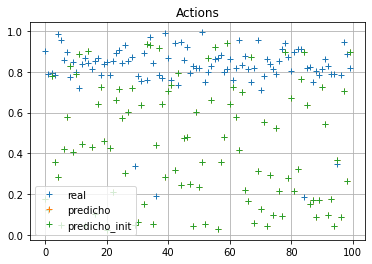

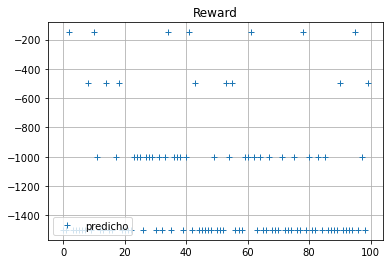

Training  | Episode: 13/100  | Episode Reward: -119050.0000  | Running Time: 7.8280
mean_real, mean_predicho :  0.7947321597741186 [0.51092494]


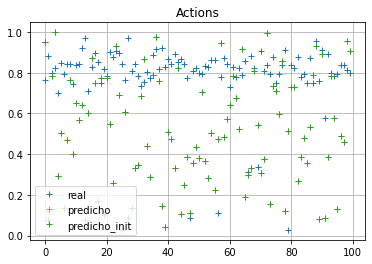

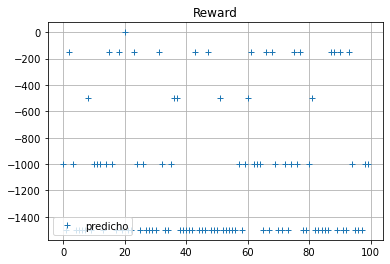

Training  | Episode: 14/100  | Episode Reward: -108900.0000  | Running Time: 7.9124
mean_real, mean_predicho :  0.8272824491752659 [0.45632386]


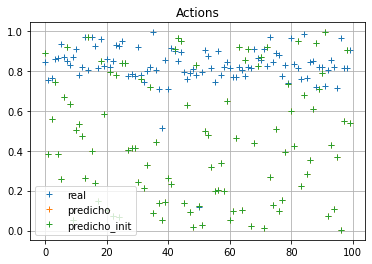

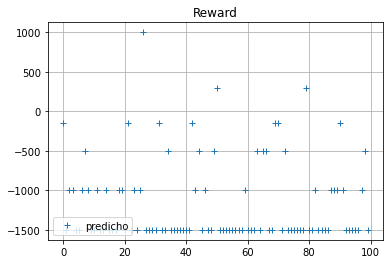

Training  | Episode: 15/100  | Episode Reward: -115950.0000  | Running Time: 7.3936
mean_real, mean_predicho :  0.831253909871643 [0.48994312]


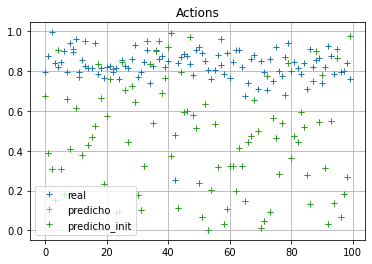

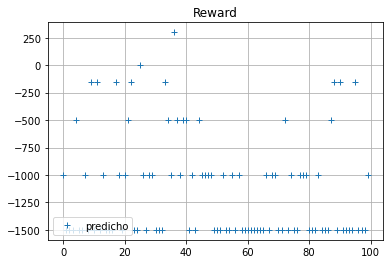

Training  | Episode: 16/100  | Episode Reward: -113400.0000  | Running Time: 7.9102
mean_real, mean_predicho :  0.8108034228339485 [0.48343384]


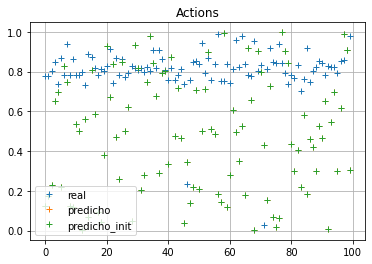

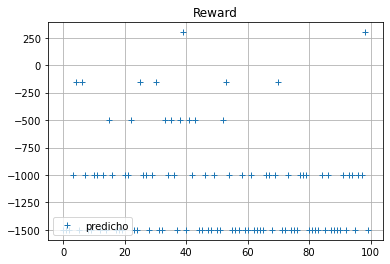

Training  | Episode: 17/100  | Episode Reward: -113800.0000  | Running Time: 7.6028
mean_real, mean_predicho :  0.817934296874896 [0.52764493]


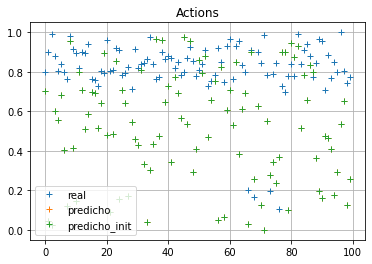

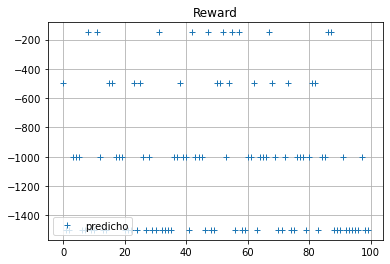

Training  | Episode: 18/100  | Episode Reward: -105150.0000  | Running Time: 7.8175
mean_real, mean_predicho :  0.8179524540051989 [0.47615188]


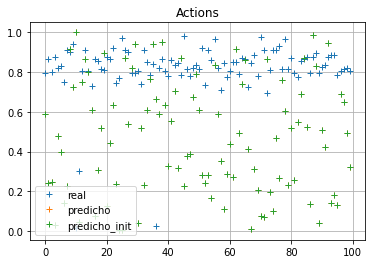

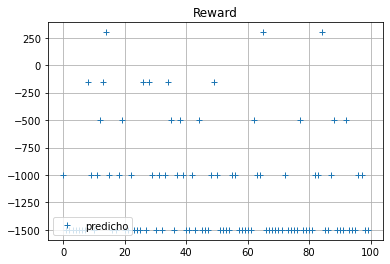

Training  | Episode: 19/100  | Episode Reward: -115500.0000  | Running Time: 7.7165
mean_real, mean_predicho :  0.8213062700171525 [0.51945454]


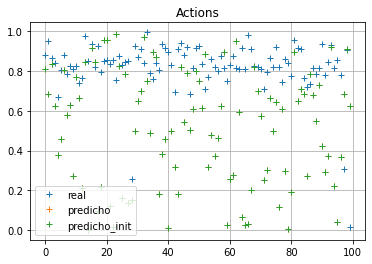

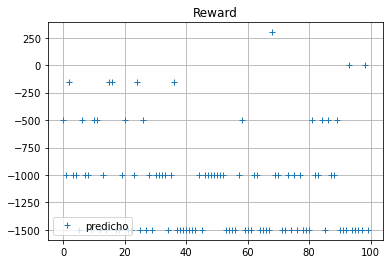

Training  | Episode: 20/100  | Episode Reward: -110450.0000  | Running Time: 7.4178
mean_real, mean_predicho :  0.8025932060246349 [0.5113044]


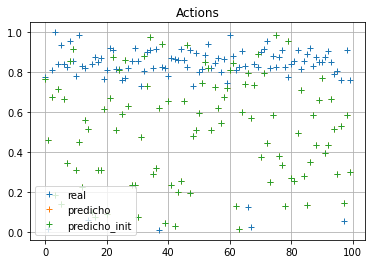

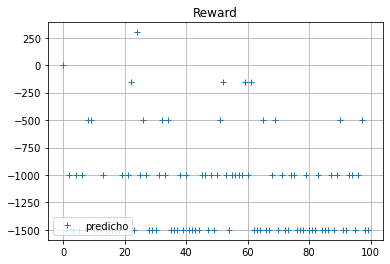

Training  | Episode: 21/100  | Episode Reward: -114800.0000  | Running Time: 7.9254
mean_real, mean_predicho :  0.8284654639458685 [0.48679912]


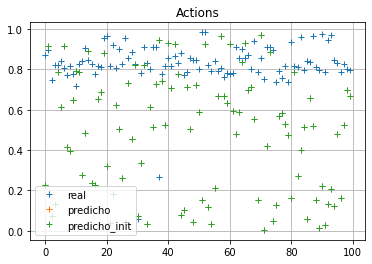

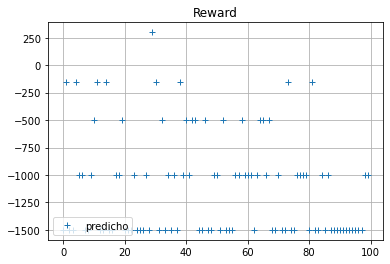

Training  | Episode: 22/100  | Episode Reward: -110900.0000  | Running Time: 7.5350
mean_real, mean_predicho :  0.8235336569404373 [0.45966384]


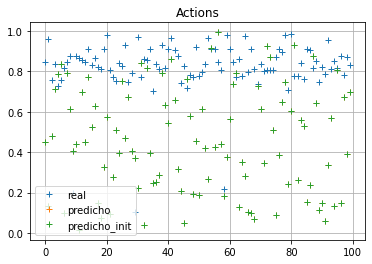

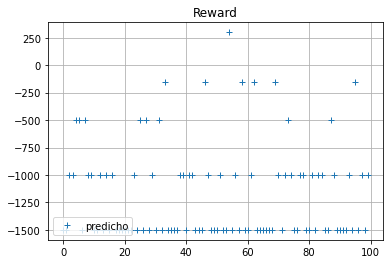

Training  | Episode: 23/100  | Episode Reward: -117600.0000  | Running Time: 7.8068
mean_real, mean_predicho :  0.8300280001689319 [0.4677826]


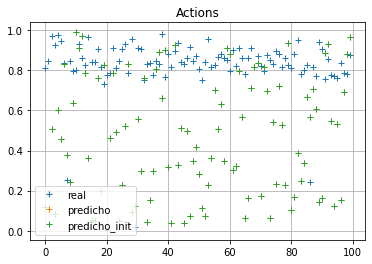

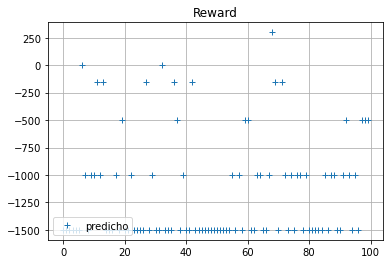

Training  | Episode: 24/100  | Episode Reward: -115750.0000  | Running Time: 7.3926
mean_real, mean_predicho :  0.8371463195163862 [0.54657847]


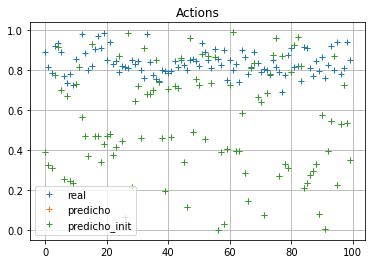

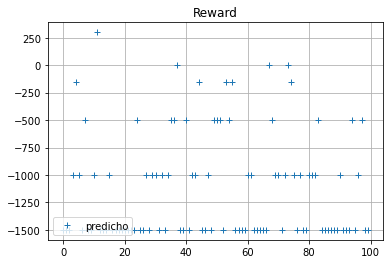

Training  | Episode: 25/100  | Episode Reward: -111950.0000  | Running Time: 7.8050
mean_real, mean_predicho :  0.8145768544107871 [0.5060919]


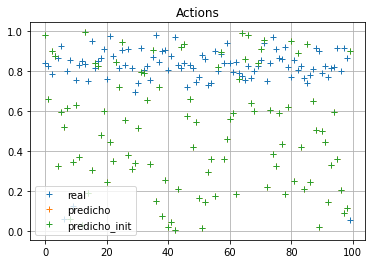

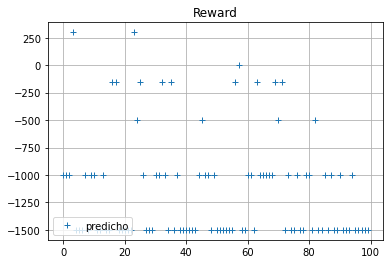

Training  | Episode: 26/100  | Episode Reward: -113250.0000  | Running Time: 7.8447
mean_real, mean_predicho :  0.8184819932183878 [0.52422523]


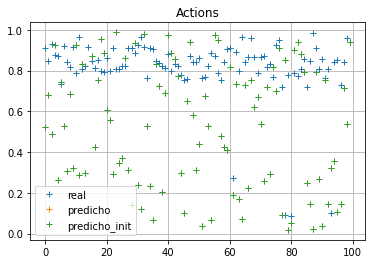

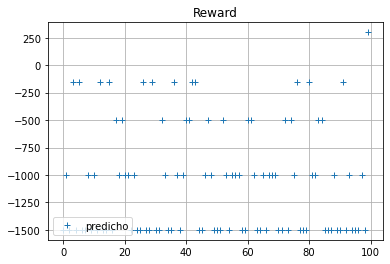

Training  | Episode: 27/100  | Episode Reward: -105500.0000  | Running Time: 8.0425
mean_real, mean_predicho :  0.7967941149265215 [0.50672716]


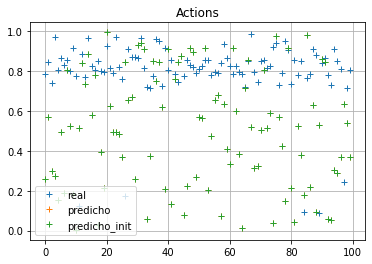

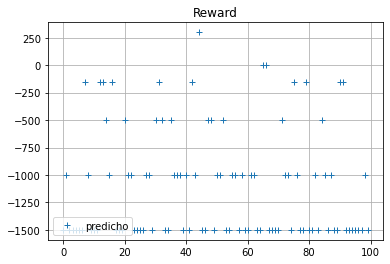

Training  | Episode: 28/100  | Episode Reward: -108700.0000  | Running Time: 7.9659
mean_real, mean_predicho :  0.8058464239538433 [0.4833954]


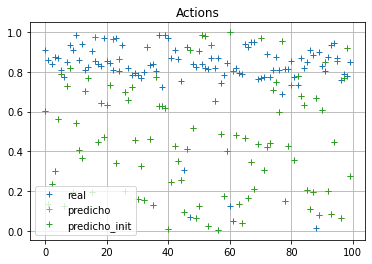

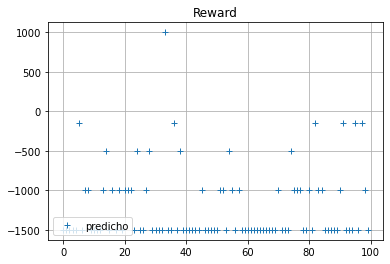

Training  | Episode: 29/100  | Episode Reward: -121900.0000  | Running Time: 7.9361
mean_real, mean_predicho :  0.8127247833163641 [0.4834626]


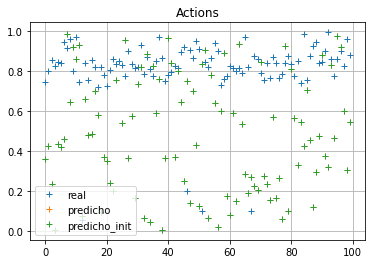

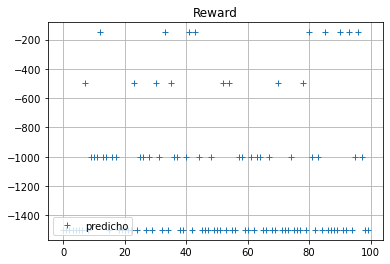

Training  | Episode: 30/100  | Episode Reward: -116350.0000  | Running Time: 8.1429
mean_real, mean_predicho :  0.8023793416334851 [0.50247777]


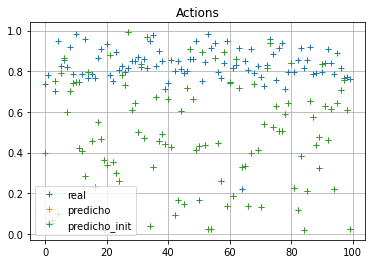

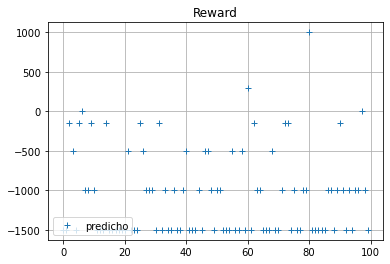

Training  | Episode: 31/100  | Episode Reward: -106700.0000  | Running Time: 8.5616
mean_real, mean_predicho :  0.8050745487987764 [0.51944786]


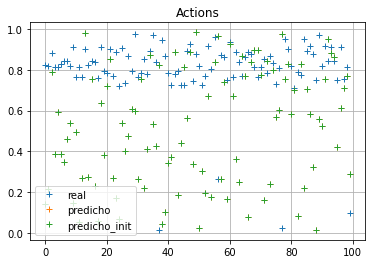

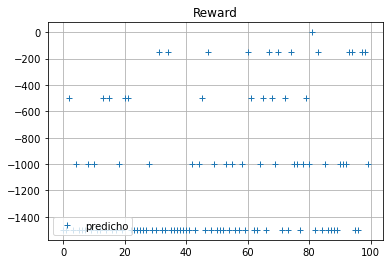

Training  | Episode: 32/100  | Episode Reward: -110300.0000  | Running Time: 8.5089
mean_real, mean_predicho :  0.8255086888203587 [0.47981307]


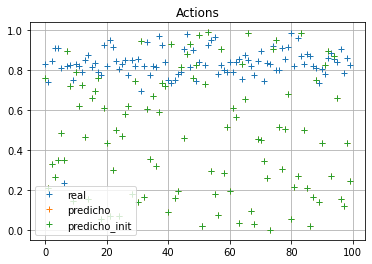

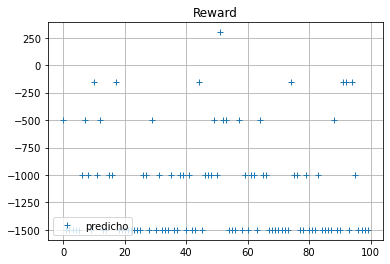

Training  | Episode: 33/100  | Episode Reward: -115750.0000  | Running Time: 8.2460
mean_real, mean_predicho :  0.8224374953533542 [0.49636605]


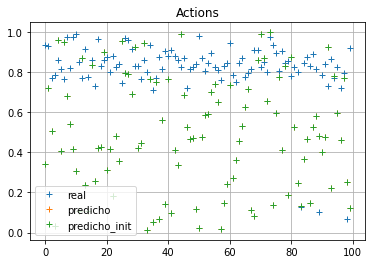

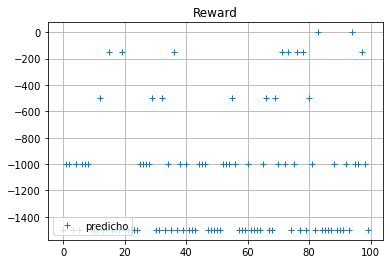

Training  | Episode: 34/100  | Episode Reward: -113700.0000  | Running Time: 7.4239
mean_real, mean_predicho :  0.8239300681305659 [0.45085663]


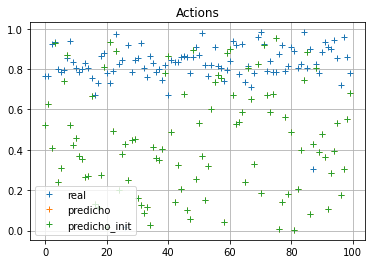

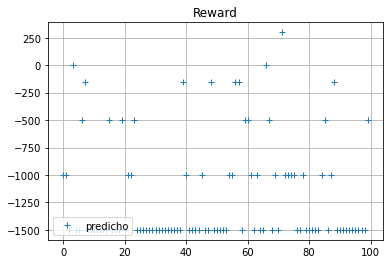

Training  | Episode: 35/100  | Episode Reward: -119100.0000  | Running Time: 7.7225
mean_real, mean_predicho :  0.792822133634723 [0.51585084]


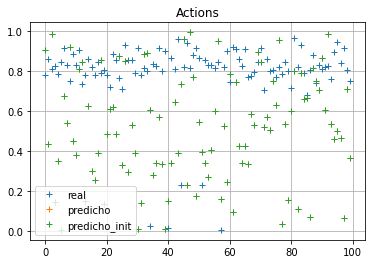

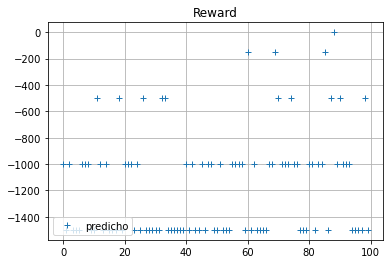

Training  | Episode: 36/100  | Episode Reward: -115950.0000  | Running Time: 8.1429
mean_real, mean_predicho :  0.8205263012041104 [0.55472094]


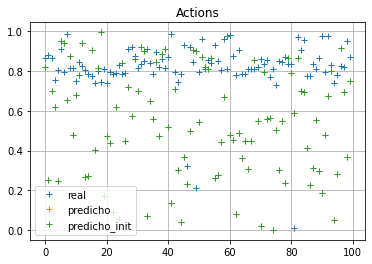

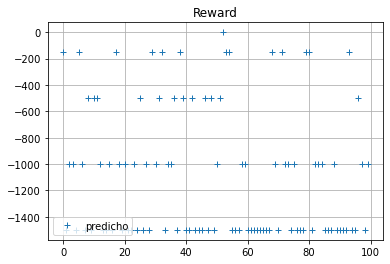

Training  | Episode: 37/100  | Episode Reward: -106450.0000  | Running Time: 7.6115
mean_real, mean_predicho :  0.825346946476379 [0.46690664]


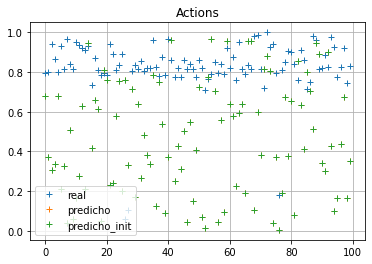

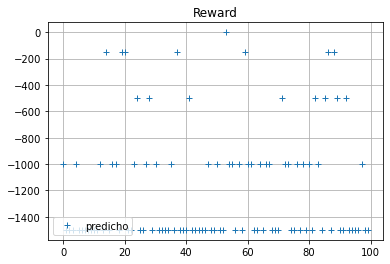

Training  | Episode: 38/100  | Episode Reward: -118050.0000  | Running Time: 7.5885
mean_real, mean_predicho :  0.8140190343124639 [0.45141912]


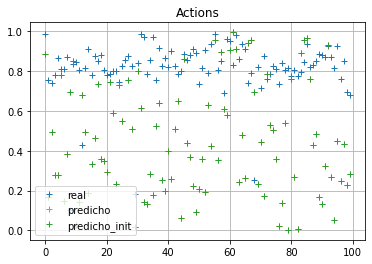

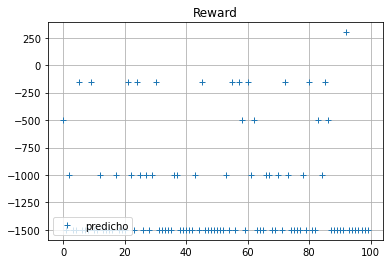

Training  | Episode: 39/100  | Episode Reward: -118000.0000  | Running Time: 7.8431
mean_real, mean_predicho :  0.8228257135422479 [0.51995087]


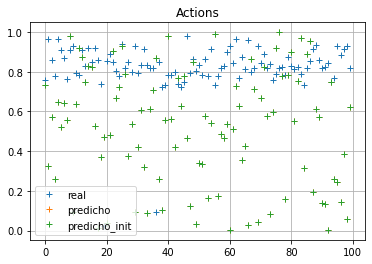

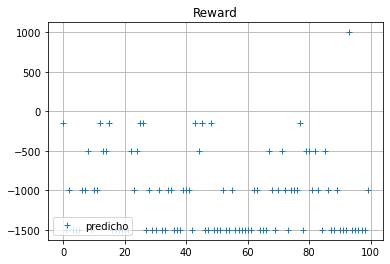

Training  | Episode: 40/100  | Episode Reward: -109350.0000  | Running Time: 8.1837
mean_real, mean_predicho :  0.8241272910747766 [0.45031005]


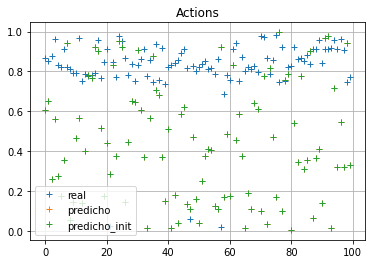

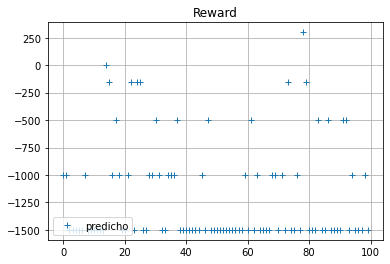

Training  | Episode: 41/100  | Episode Reward: -119100.0000  | Running Time: 7.6389
mean_real, mean_predicho :  0.8158786270587816 [0.4953496]


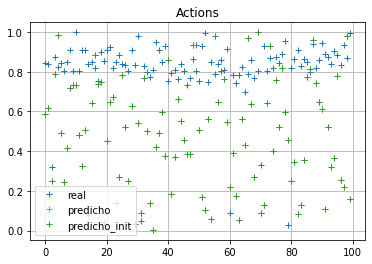

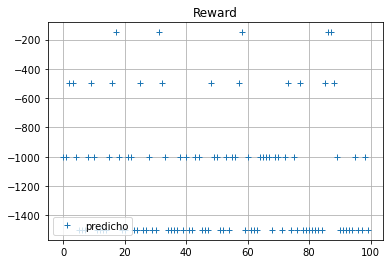

Training  | Episode: 42/100  | Episode Reward: -115250.0000  | Running Time: 7.5324
mean_real, mean_predicho :  0.7932664958500097 [0.49011868]


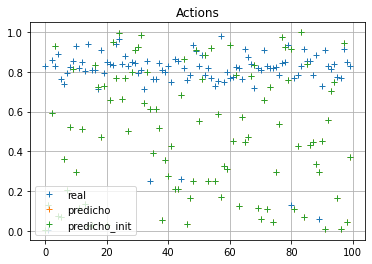

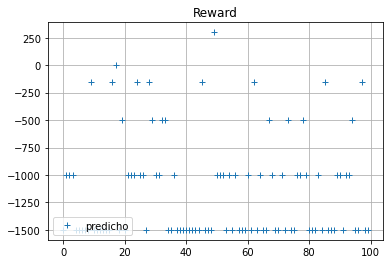

Training  | Episode: 43/100  | Episode Reward: -113900.0000  | Running Time: 7.4627
mean_real, mean_predicho :  0.8115839175780718 [0.5139611]


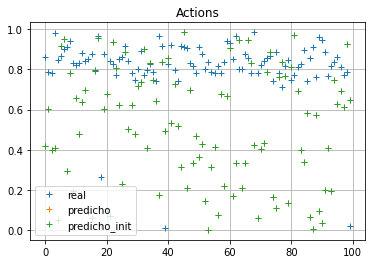

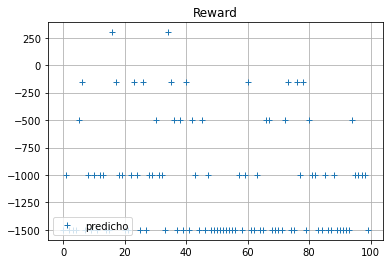

Training  | Episode: 44/100  | Episode Reward: -108400.0000  | Running Time: 7.8009
mean_real, mean_predicho :  0.8206531864482983 [0.5205681]


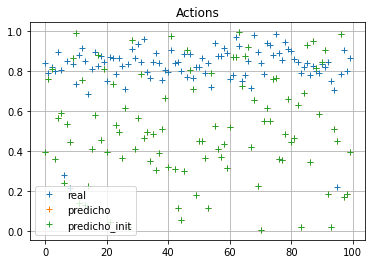

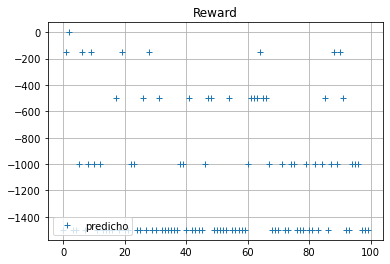

Training  | Episode: 45/100  | Episode Reward: -112700.0000  | Running Time: 8.2210
mean_real, mean_predicho :  0.8000968288278494 [0.48248506]


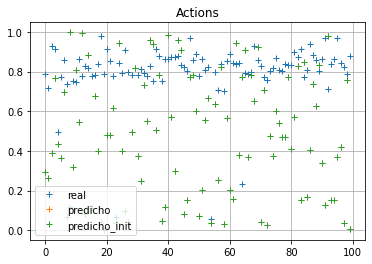

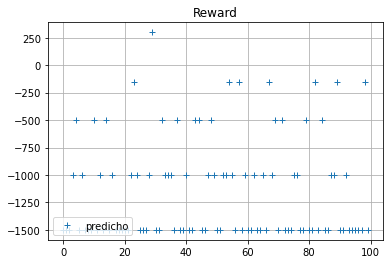

Training  | Episode: 46/100  | Episode Reward: -114250.0000  | Running Time: 7.9601
mean_real, mean_predicho :  0.8174827278651727 [0.5300753]


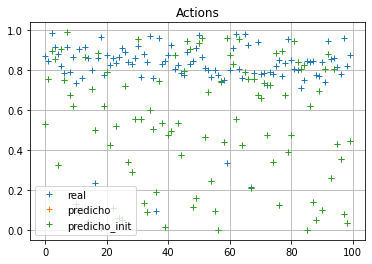

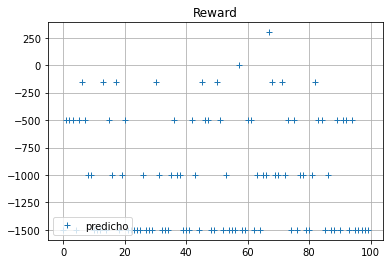

Training  | Episode: 47/100  | Episode Reward: -102050.0000  | Running Time: 7.6214
mean_real, mean_predicho :  0.7999532728661474 [0.53190285]


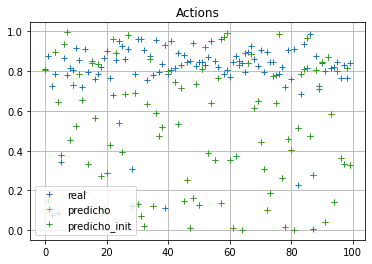

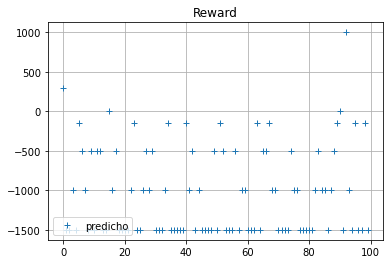

Training  | Episode: 48/100  | Episode Reward: -103200.0000  | Running Time: 7.4770
mean_real, mean_predicho :  0.8145488857048179 [0.47666618]


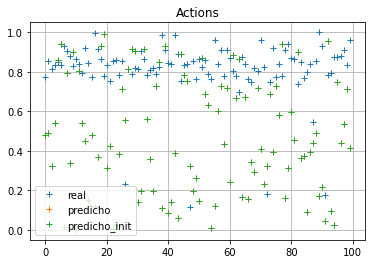

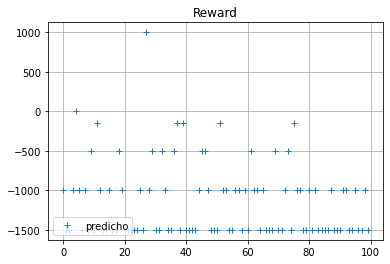

Training  | Episode: 49/100  | Episode Reward: -114250.0000  | Running Time: 7.6182
mean_real, mean_predicho :  0.8047648098679328 [0.51150423]


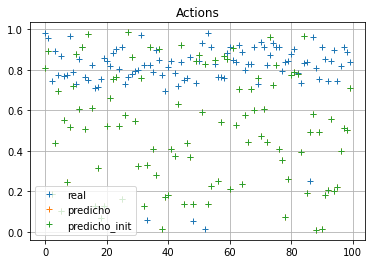

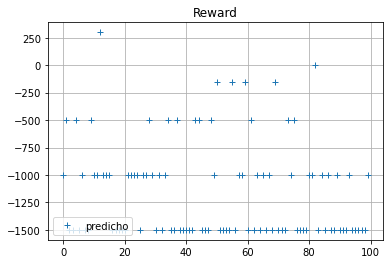

Training  | Episode: 50/100  | Episode Reward: -114300.0000  | Running Time: 7.8729
mean_real, mean_predicho :  0.816923568597374 [0.49960732]


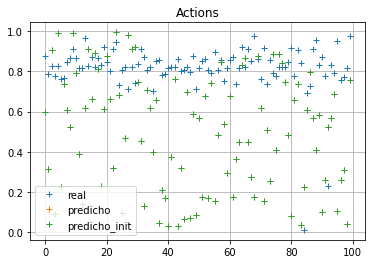

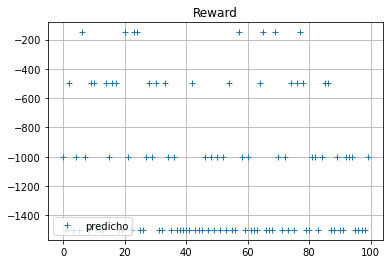

Training  | Episode: 51/100  | Episode Reward: -109700.0000  | Running Time: 7.8877
mean_real, mean_predicho :  0.8191638658434962 [0.54693055]


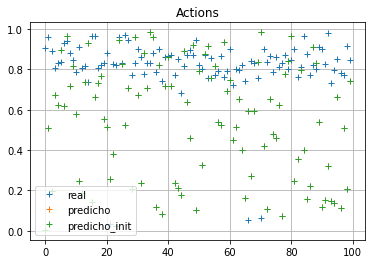

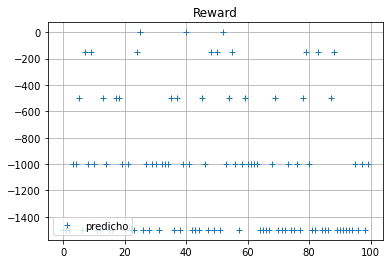

Training  | Episode: 52/100  | Episode Reward: -106350.0000  | Running Time: 7.4793
mean_real, mean_predicho :  0.8224397365005861 [0.48062405]


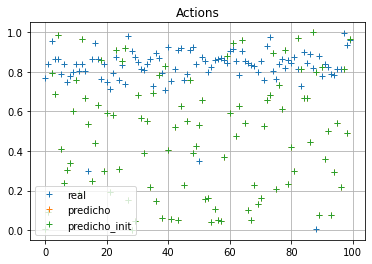

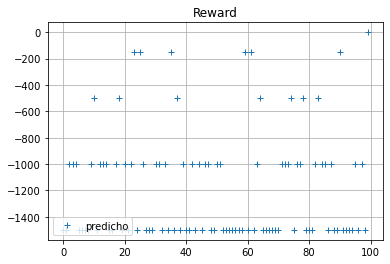

Training  | Episode: 53/100  | Episode Reward: -116900.0000  | Running Time: 7.9682
mean_real, mean_predicho :  0.8225740821981506 [0.44211784]


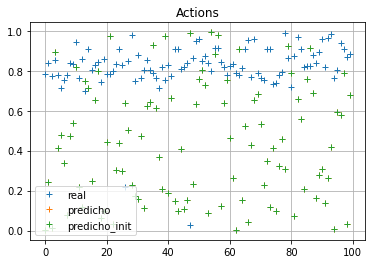

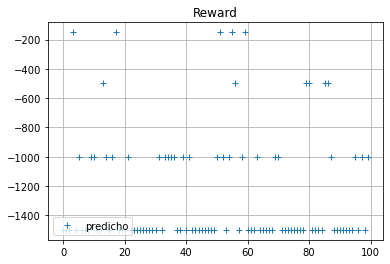

Training  | Episode: 54/100  | Episode Reward: -125250.0000  | Running Time: 8.5132
mean_real, mean_predicho :  0.8246223882467812 [0.4741192]


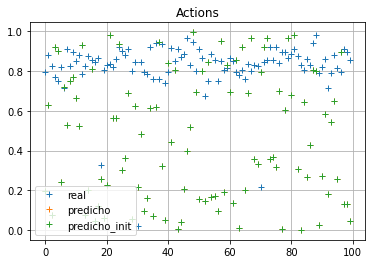

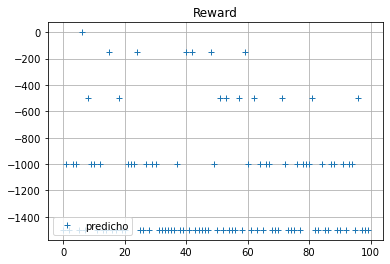

Training  | Episode: 55/100  | Episode Reward: -116900.0000  | Running Time: 7.8393
mean_real, mean_predicho :  0.8347085190725078 [0.5277617]


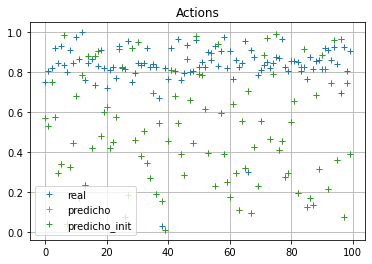

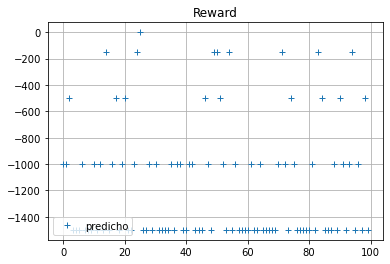

Training  | Episode: 56/100  | Episode Reward: -114700.0000  | Running Time: 7.5141
mean_real, mean_predicho :  0.8273080259428837 [0.46264294]


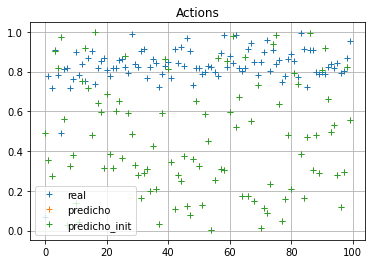

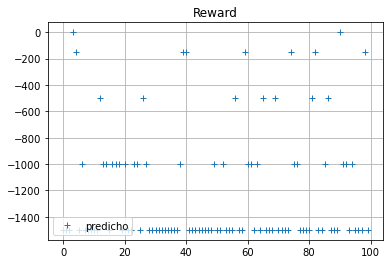

Training  | Episode: 57/100  | Episode Reward: -119550.0000  | Running Time: 7.5862
mean_real, mean_predicho :  0.826413740751778 [0.56623226]


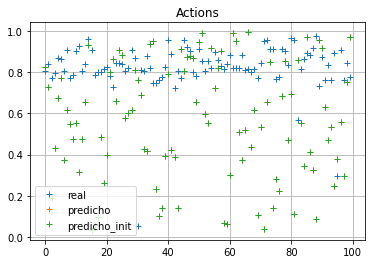

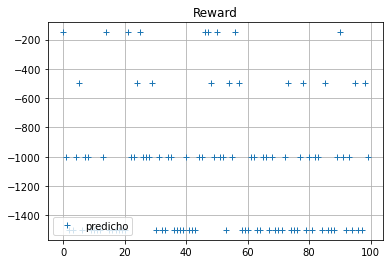

Training  | Episode: 58/100  | Episode Reward: -109850.0000  | Running Time: 7.4874
mean_real, mean_predicho :  0.8157413901375393 [0.5226118]


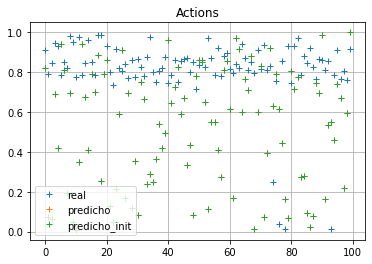

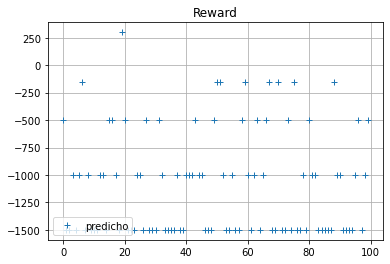

Training  | Episode: 59/100  | Episode Reward: -108900.0000  | Running Time: 7.5432
mean_real, mean_predicho :  0.8176185244904752 [0.4936449]


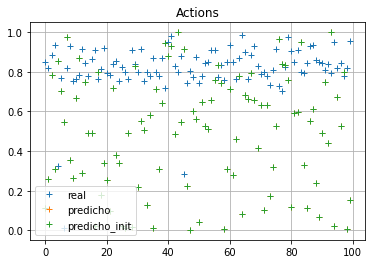

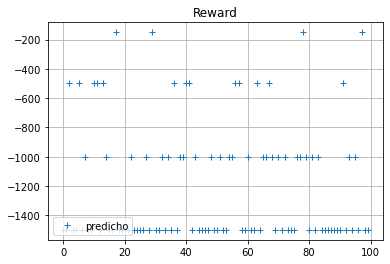

Training  | Episode: 60/100  | Episode Reward: -118600.0000  | Running Time: 7.6666
mean_real, mean_predicho :  0.8003261746119213 [0.4892074]


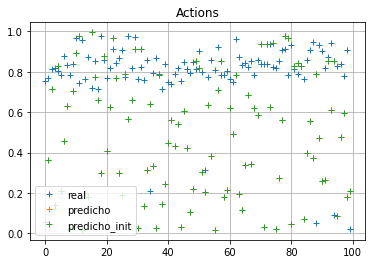

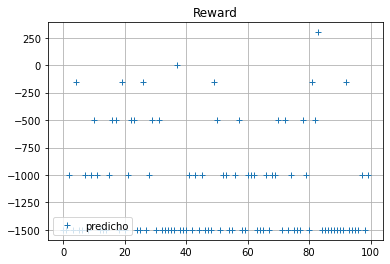

Training  | Episode: 61/100  | Episode Reward: -114100.0000  | Running Time: 7.3214
mean_real, mean_predicho :  0.7827236778209301 [0.4944792]


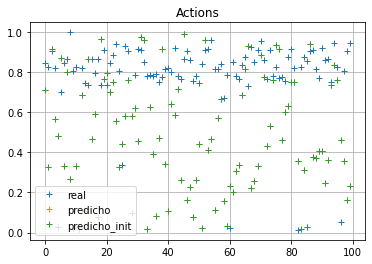

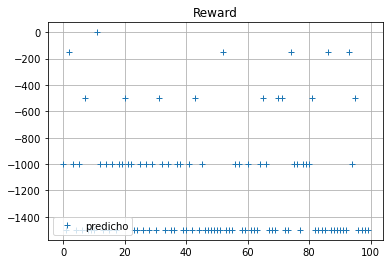

Training  | Episode: 62/100  | Episode Reward: -117750.0000  | Running Time: 7.6587
mean_real, mean_predicho :  0.8094211709967121 [0.48491088]


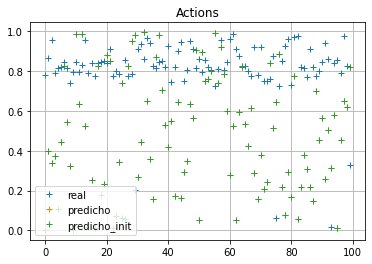

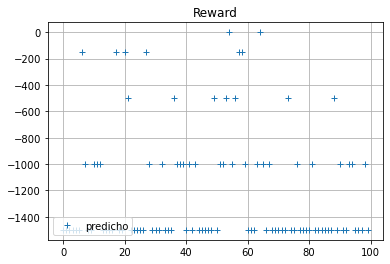

Training  | Episode: 63/100  | Episode Reward: -119900.0000  | Running Time: 7.4977
mean_real, mean_predicho :  0.8188037954899795 [0.49351037]


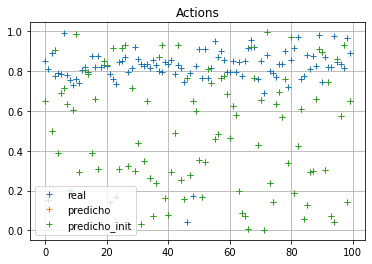

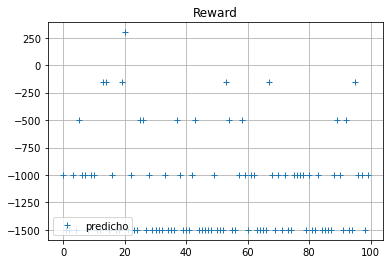

Training  | Episode: 64/100  | Episode Reward: -115600.0000  | Running Time: 8.1118
mean_real, mean_predicho :  0.8072825813090102 [0.4766324]


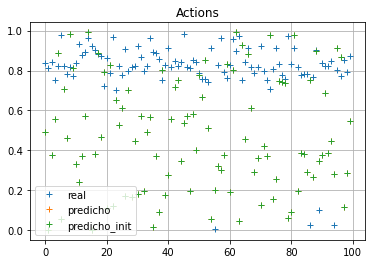

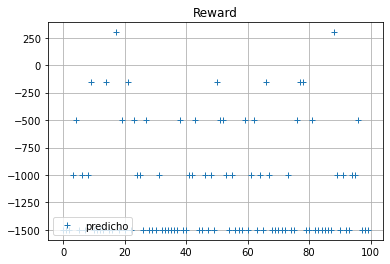

Training  | Episode: 65/100  | Episode Reward: -113950.0000  | Running Time: 8.2671
mean_real, mean_predicho :  0.810724497484437 [0.5218964]


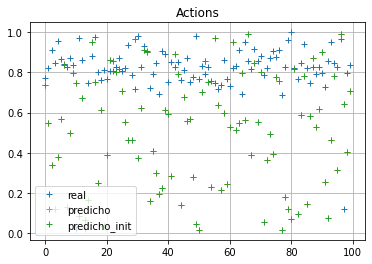

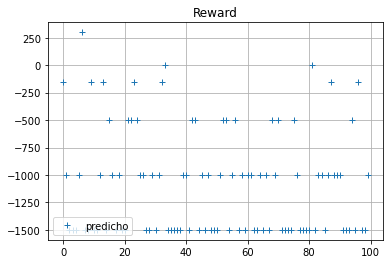

Training  | Episode: 66/100  | Episode Reward: -108250.0000  | Running Time: 7.5778
mean_real, mean_predicho :  0.818273373858474 [0.5290795]


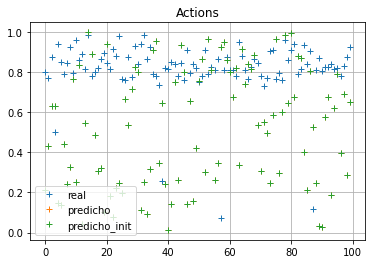

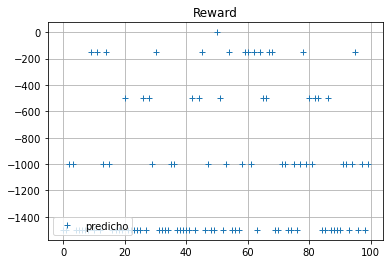

Training  | Episode: 67/100  | Episode Reward: -106600.0000  | Running Time: 7.5173
mean_real, mean_predicho :  0.8374828662180426 [0.5398209]


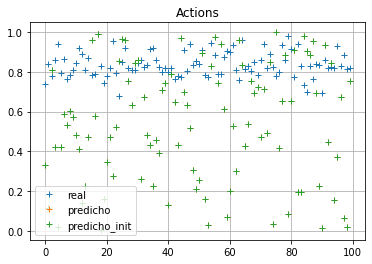

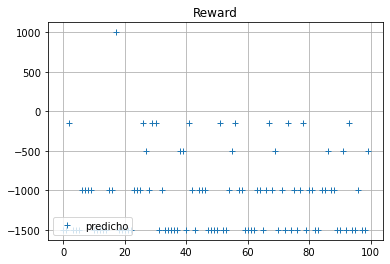

Training  | Episode: 68/100  | Episode Reward: -108650.0000  | Running Time: 7.5746
mean_real, mean_predicho :  0.8044415539856604 [0.5063417]


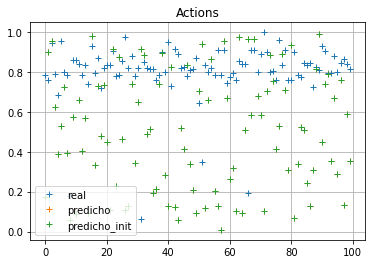

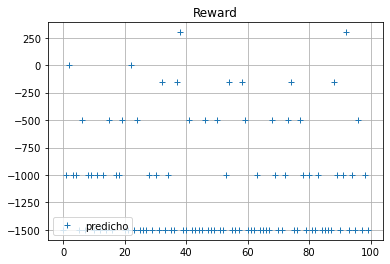

Training  | Episode: 69/100  | Episode Reward: -111800.0000  | Running Time: 7.4811
mean_real, mean_predicho :  0.8113328156965892 [0.48838627]


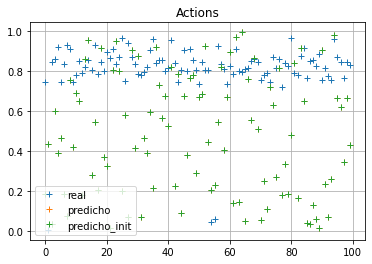

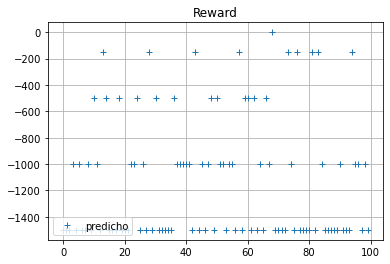

Training  | Episode: 70/100  | Episode Reward: -111350.0000  | Running Time: 8.0232
mean_real, mean_predicho :  0.8019504652586664 [0.47116172]


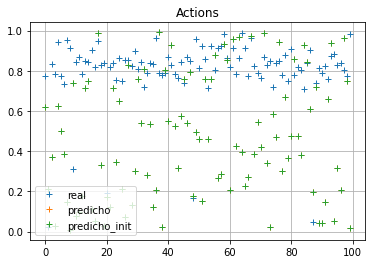

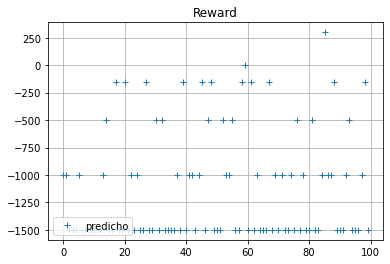

Training  | Episode: 71/100  | Episode Reward: -111850.0000  | Running Time: 7.6339
mean_real, mean_predicho :  0.812025949971862 [0.4781809]


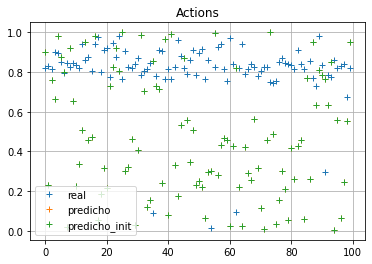

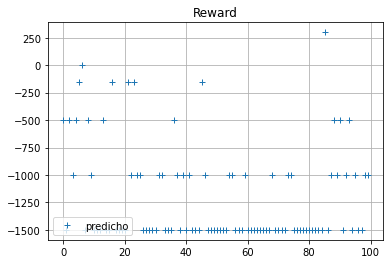

Training  | Episode: 72/100  | Episode Reward: -119450.0000  | Running Time: 7.5055
mean_real, mean_predicho :  0.8140027928610629 [0.54400367]


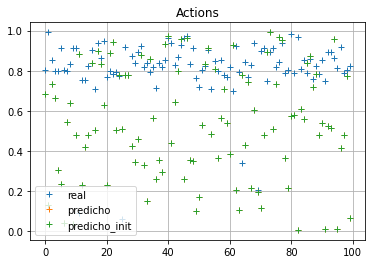

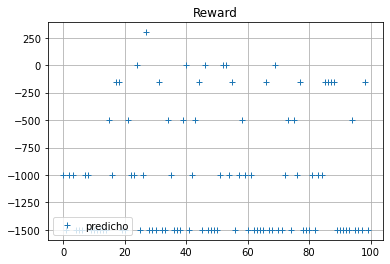

Training  | Episode: 73/100  | Episode Reward: -103500.0000  | Running Time: 7.9252
mean_real, mean_predicho :  0.8217571818664393 [0.4974171]


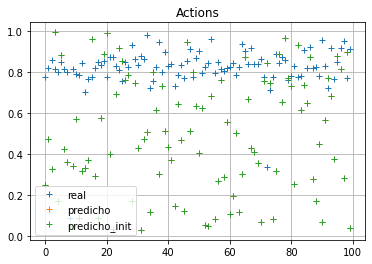

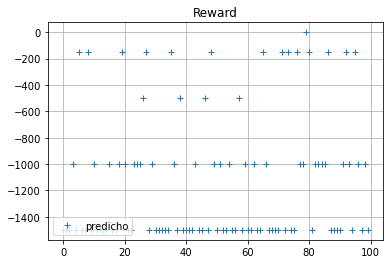

Training  | Episode: 74/100  | Episode Reward: -112100.0000  | Running Time: 7.6406
mean_real, mean_predicho :  0.8151800207507126 [0.46242958]


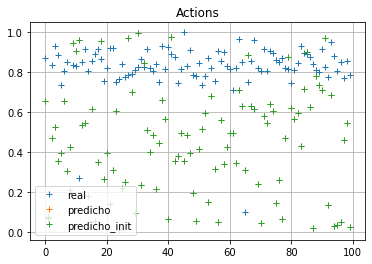

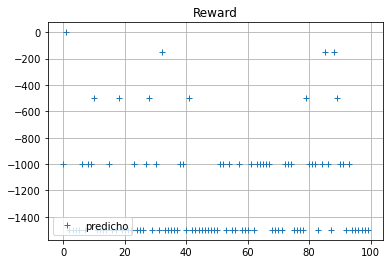

Training  | Episode: 75/100  | Episode Reward: -122950.0000  | Running Time: 7.3610
mean_real, mean_predicho :  0.8288230004766306 [0.49102098]


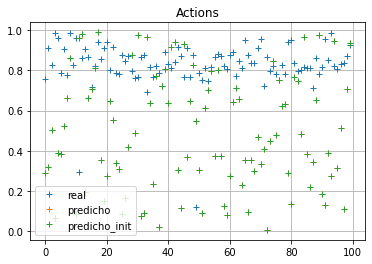

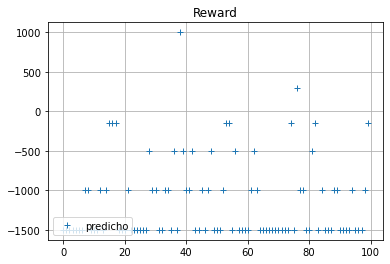

Training  | Episode: 76/100  | Episode Reward: -115400.0000  | Running Time: 7.4801
mean_real, mean_predicho :  0.8186043278693285 [0.48268622]


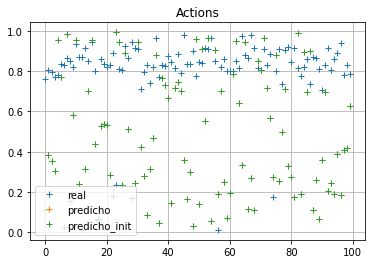

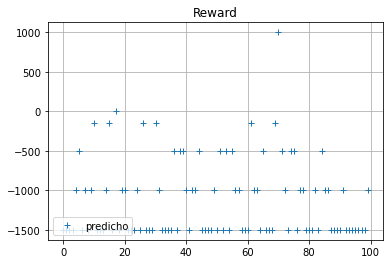

Training  | Episode: 77/100  | Episode Reward: -112900.0000  | Running Time: 7.2593
mean_real, mean_predicho :  0.8122636466253051 [0.45736125]


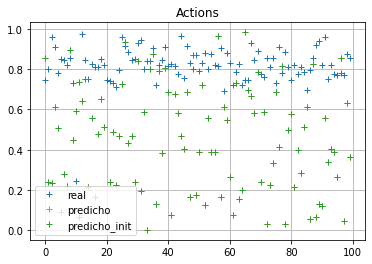

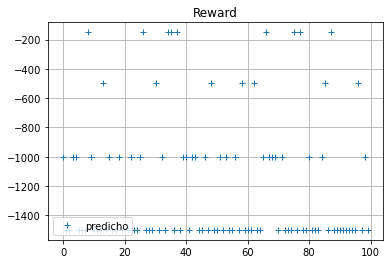

Training  | Episode: 78/100  | Episode Reward: -118350.0000  | Running Time: 7.5181
mean_real, mean_predicho :  0.8266650670169753 [0.53731185]


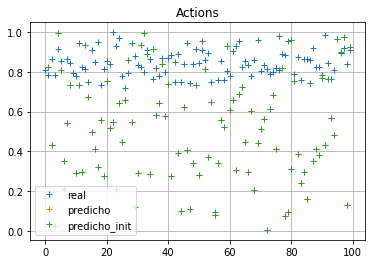

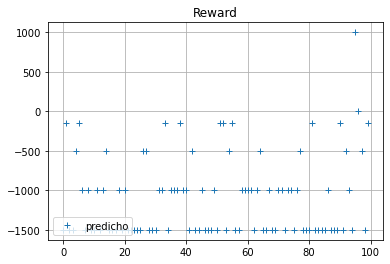

Training  | Episode: 79/100  | Episode Reward: -108500.0000  | Running Time: 7.2302
mean_real, mean_predicho :  0.8301007980758647 [0.5250207]


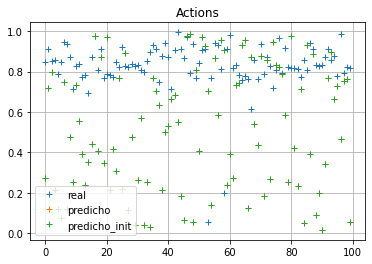

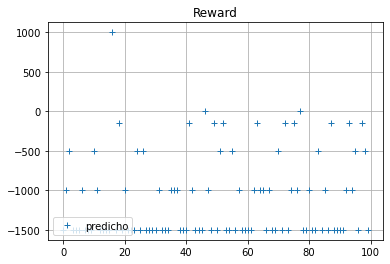

Training  | Episode: 80/100  | Episode Reward: -110500.0000  | Running Time: 7.8843
mean_real, mean_predicho :  0.8286494076092074 [0.49041015]


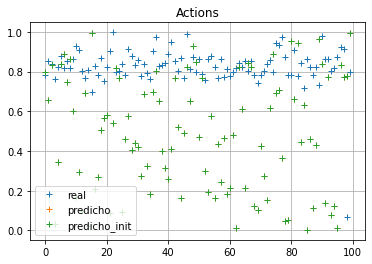

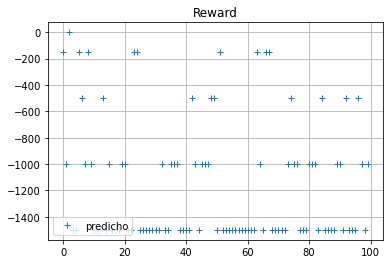

Training  | Episode: 81/100  | Episode Reward: -114850.0000  | Running Time: 7.4066
mean_real, mean_predicho :  0.8367507898797083 [0.4766615]


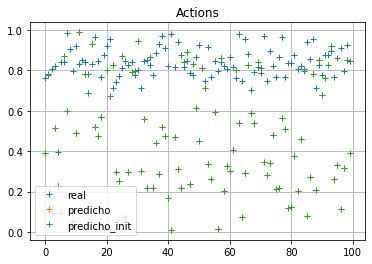

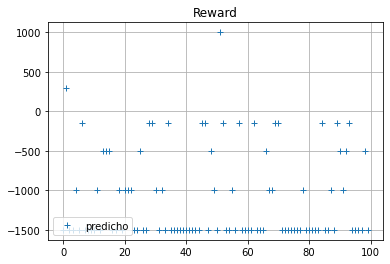

Training  | Episode: 82/100  | Episode Reward: -110300.0000  | Running Time: 7.6822
mean_real, mean_predicho :  0.803086658018302 [0.4554769]


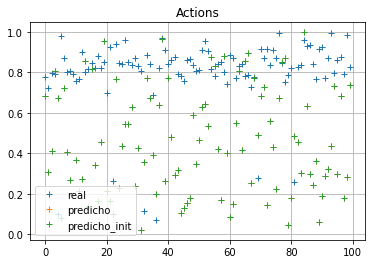

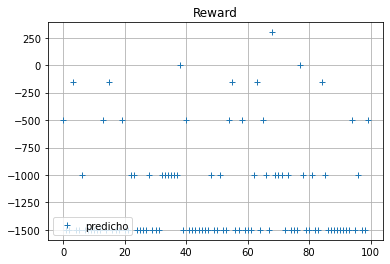

Training  | Episode: 83/100  | Episode Reward: -118450.0000  | Running Time: 7.6682
mean_real, mean_predicho :  0.8179307981252133 [0.5190046]


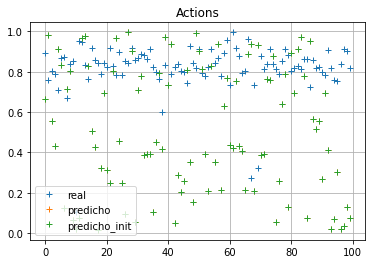

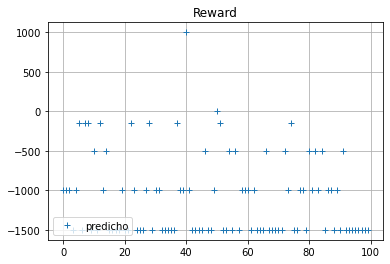

Training  | Episode: 84/100  | Episode Reward: -109850.0000  | Running Time: 7.5421
mean_real, mean_predicho :  0.8190966836811379 [0.47821525]


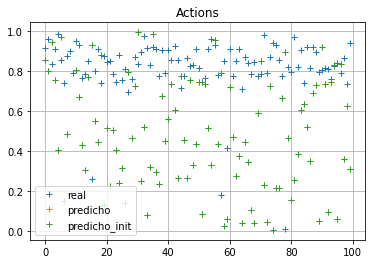

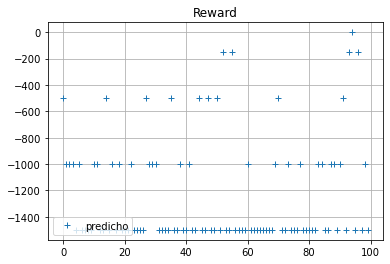

Training  | Episode: 85/100  | Episode Reward: -122100.0000  | Running Time: 7.7323
mean_real, mean_predicho :  0.8027274648009147 [0.453574]


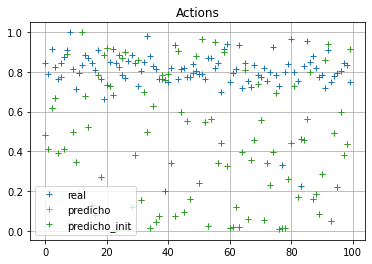

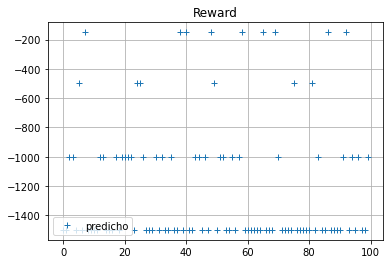

Training  | Episode: 86/100  | Episode Reward: -118850.0000  | Running Time: 7.3570
mean_real, mean_predicho :  0.7975459891096751 [0.47233808]


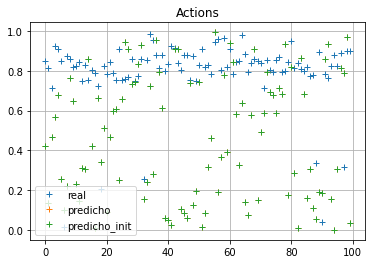

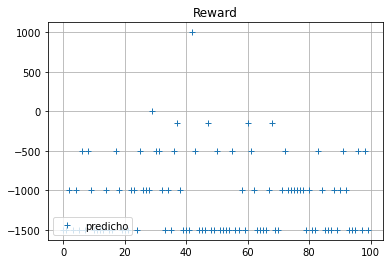

Training  | Episode: 87/100  | Episode Reward: -110600.0000  | Running Time: 7.6256
mean_real, mean_predicho :  0.8287152718656856 [0.51603335]


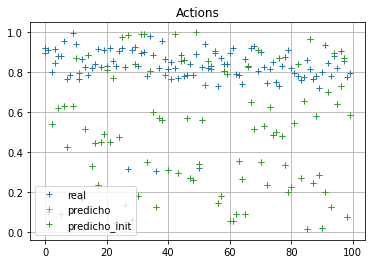

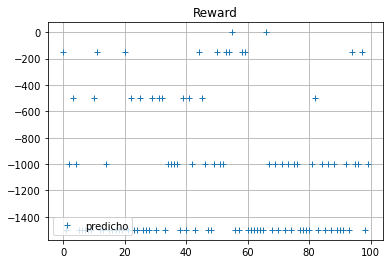

Training  | Episode: 88/100  | Episode Reward: -108150.0000  | Running Time: 7.5556
mean_real, mean_predicho :  0.7999093482793843 [0.49625373]


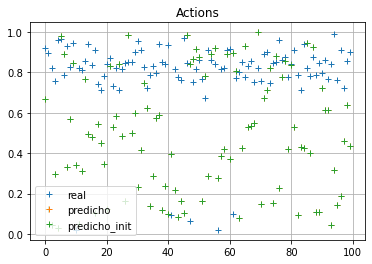

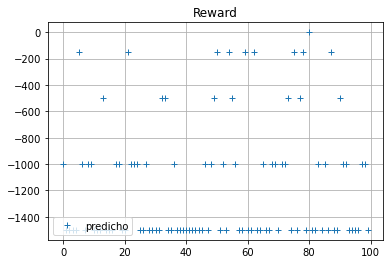

Training  | Episode: 89/100  | Episode Reward: -115350.0000  | Running Time: 7.9580
mean_real, mean_predicho :  0.8021980054157202 [0.46587417]


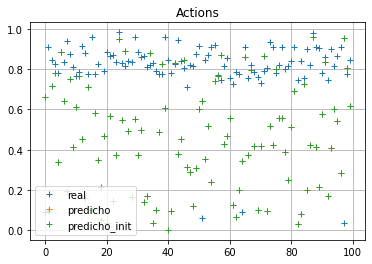

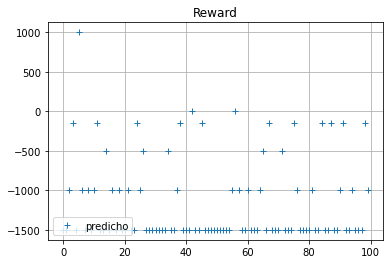

Training  | Episode: 90/100  | Episode Reward: -115650.0000  | Running Time: 7.5631
mean_real, mean_predicho :  0.8100163225790188 [0.52007776]


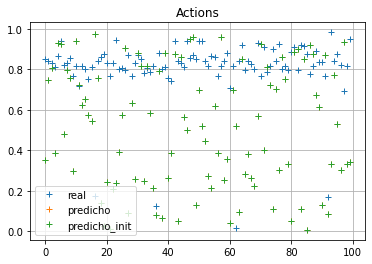

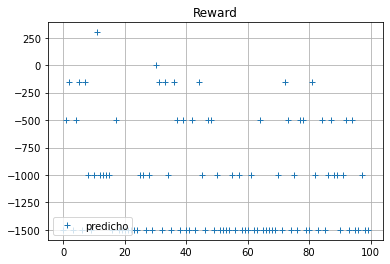

Training  | Episode: 91/100  | Episode Reward: -107050.0000  | Running Time: 7.6020
mean_real, mean_predicho :  0.8396028429170467 [0.5314453]


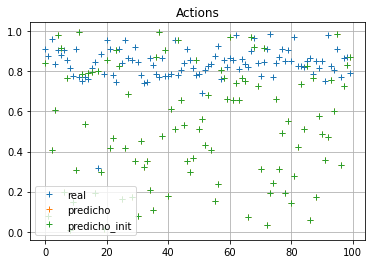

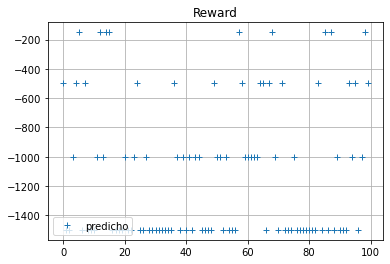

Training  | Episode: 92/100  | Episode Reward: -110850.0000  | Running Time: 7.4819
mean_real, mean_predicho :  0.8255463821853614 [0.510009]


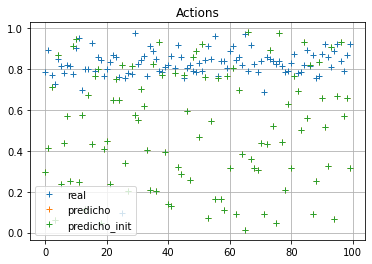

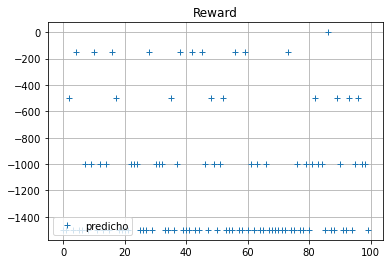

Training  | Episode: 93/100  | Episode Reward: -113000.0000  | Running Time: 7.6700
mean_real, mean_predicho :  0.8242484319907768 [0.48805764]


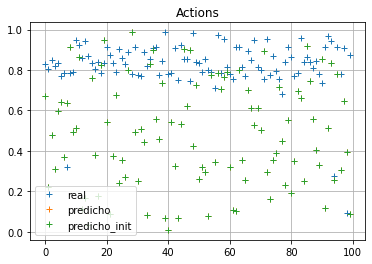

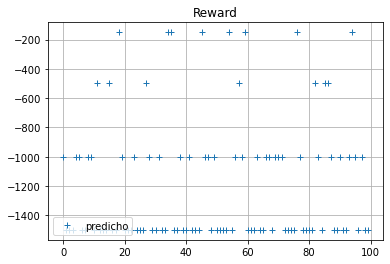

Training  | Episode: 94/100  | Episode Reward: -117700.0000  | Running Time: 7.3925
mean_real, mean_predicho :  0.8046814962245825 [0.5436301]


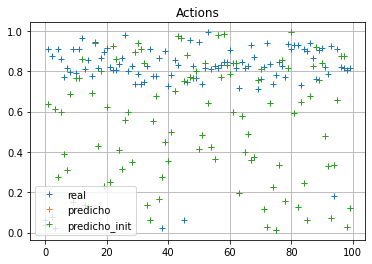

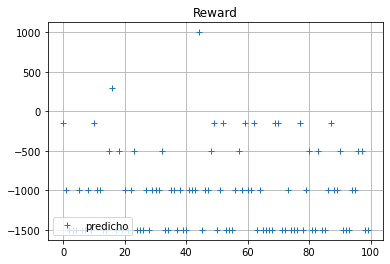

Training  | Episode: 95/100  | Episode Reward: -105200.0000  | Running Time: 7.7100
mean_real, mean_predicho :  0.8234332992042154 [0.52130336]


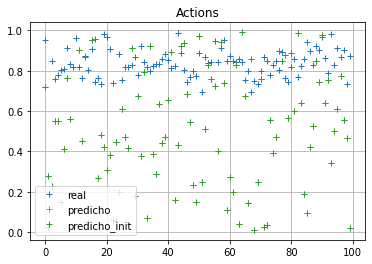

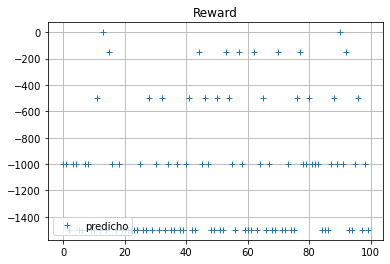

Training  | Episode: 96/100  | Episode Reward: -109200.0000  | Running Time: 7.5379
mean_real, mean_predicho :  0.8124245987660653 [0.45813414]


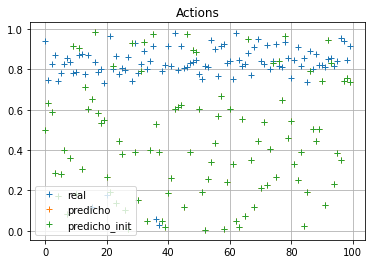

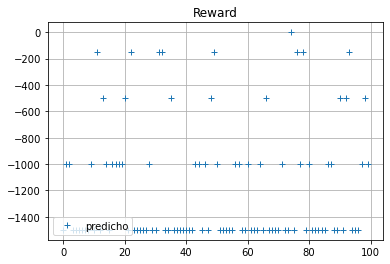

Training  | Episode: 97/100  | Episode Reward: -117700.0000  | Running Time: 7.6842
mean_real, mean_predicho :  0.8074295650781929 [0.46517327]


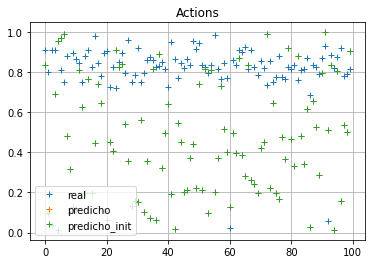

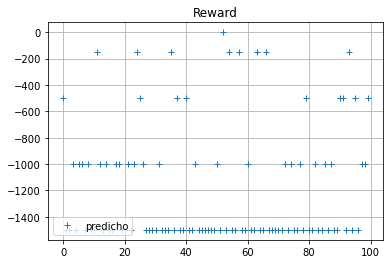

Training  | Episode: 98/100  | Episode Reward: -117200.0000  | Running Time: 7.6699
mean_real, mean_predicho :  0.8299979464053119 [0.49213052]


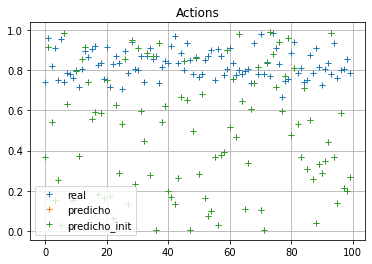

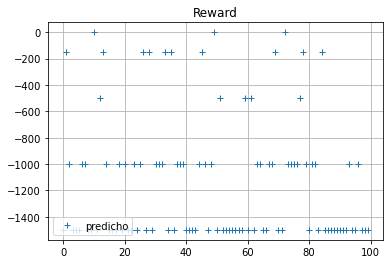

Training  | Episode: 99/100  | Episode Reward: -112000.0000  | Running Time: 7.5056
mean_real, mean_predicho :  0.8042360324987521 [0.4598009]


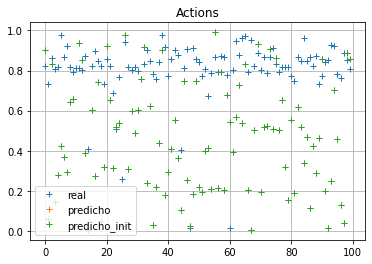

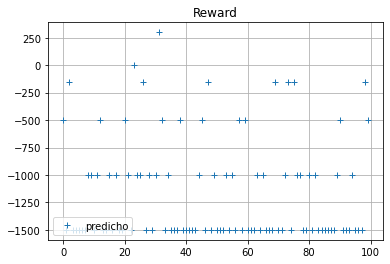

Training  | Episode: 100/100  | Episode Reward: -115250.0000  | Running Time: 7.6534


In [13]:
# Training loop
frame_idx = 0
all_episode_reward = []
episode_reward_list = []
all_q_value_loss1 = []
all_q_value_loss2 = []
all_policy_loss = []

# need an extra call here to make inside functions be able to use model.forward
state = tf.cast(env._next_obs(), dtype=tf.float32)
agent.policy_net([state])
agent.target_policy_net([state])


for episode in range(TRAIN_EPISODES):
    
    t0 = time.time()
    state = tf.cast(env._next_obs(), dtype=tf.float32)
    episode_reward = 0

    for step in range(MAX_STEPS):
        action = agent.policy_net.sample_action()[0]
        action_init = action
        
        next_state, reward, done, expected_action = env.step(action)
        next_state = next_state.astype(np.float32)
        done = 1 if done is True else 0

        replay_buffer.push(state, action, action_init, reward, next_state, expected_action, done)
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > BATCH_SIZE:
            if RENDER and step == MAX_STEPS-1:
                env.render(replay_buffer.slices(100))
            
            for i in range(UPDATE_ITR):
                history = agent.update(BATCH_SIZE, EVAL_NOISE_SCALE, REWARD_SCALE)
                
                if len(history) >= 2:
                    all_q_value_loss1.append(history[0][1])
                    all_q_value_loss2.append(history[1][1])
                if len(history) == 3:
                    all_policy_loss.append(history[2][1])
                    

        if done:
            break
    if episode == 0:
        all_episode_reward.append(episode_reward)
    else:
        all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
    episode_reward_list.append(episode_reward)
    print(
          'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
              episode + 1, TRAIN_EPISODES, episode_reward,
              time.time() - t0
          )
    )
    
#agent.save()

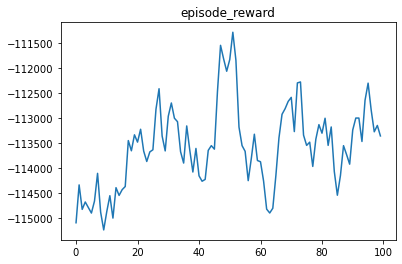

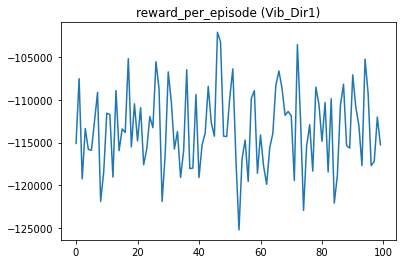

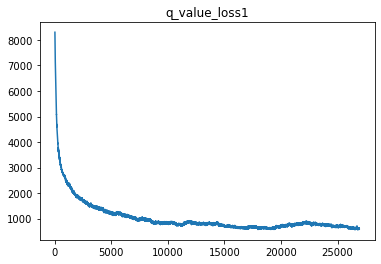

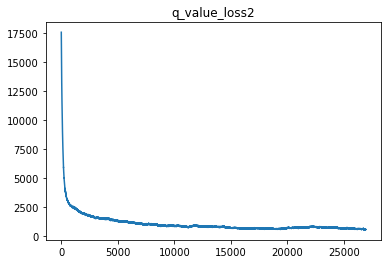

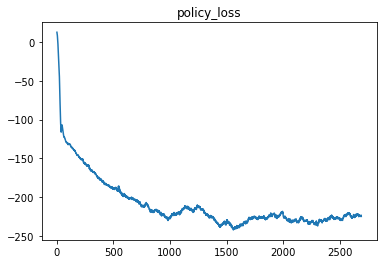

In [14]:
plt.plot(all_episode_reward)
plt.title('episode_reward')
plt.show()
plt.plot(episode_reward_list)
plt.title('reward_per_episode (Vib_Dir1)')
plt.show()
plt.plot(all_q_value_loss1)
plt.title('q_value_loss1')
plt.show()
plt.plot(all_q_value_loss2)
plt.title('q_value_loss2')
plt.show()
plt.plot(all_policy_loss)
plt.title('policy_loss')
plt.show()


In [15]:
# Save model

import tensorlayer as tl
agent.save()

[TL] [*] Saving TL weights into models/model_policy_net_1.npz
[TL] [*] Saved


E:\ANACONDA\envs\tf\lib\site-packages\numpy\lib\npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


### Predictions visualisation

In [16]:
y_prediction = agent.get_prediction(X_test)

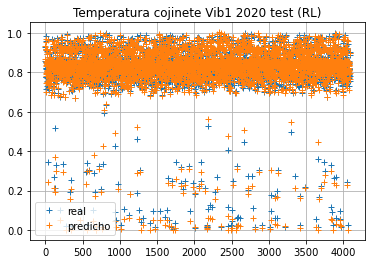

In [17]:
y_prediction = agent.get_prediction(X_test)

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_test), label='real', marker='+', linestyle='None')
plt.plot(np.array(y_prediction), label='predicho', marker='+', linestyle='None')
plt.title('Temperatura cojinete Vib1 2020 test (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()


In [18]:
y_prediction_t = agent.get_prediction(X_train)

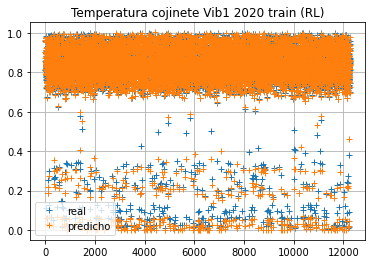

In [19]:
y_prediction_t = agent.get_prediction(X_train)

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_train), label='real', marker='+', linestyle='None')
plt.plot(np.array(y_prediction_t), label='predicho', marker='+', linestyle='None')
plt.title('Temperatura cojinete Vib1 2020 train (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

### STD/RMSE computation

In [20]:
# Training/Test error
error_train_2020 = []
for i in range(len(y_train)):
    x=y_train[i]-y_prediction_t[i]
    error_train_2020.append(x.numpy())

error_test_2020 = []
for i in range(len(y_test)):
    x=y_test[i]-y_prediction[i]
    error_test_2020.append(x.numpy())

error_train_2020 = np.array(error_train_2020)
error_test_2020 = np.array(error_test_2020)

In [21]:
# Mean computation
mean = error_train_2020.mean()
print("Mean train : ", mean)

mean_test = error_test_2020.mean()
print("Mean test : ", mean_test)

# STD computation
std = error_train_2020.std()
print("Std train : ", std)

std_test = error_test_2020.std()
print("Std test : ", std_test)

Mean train :  -0.0036897694
Mean test :  -0.00421264
Std train :  0.016835595
Std test :  0.016764237


In [22]:
# RMSE computation
print('RMSE train 2020', math.sqrt(reduce_mean(square(error_train_2020))).numpy())
print('RMSE test 2020', math.sqrt(reduce_mean(square(error_test_2020))).numpy())

RMSE train 2020 0.017235186
RMSE test 2020 0.017285425


In [23]:
# desviacion de test 2020
desviacion_test_2020 = error_test_2020 -mean

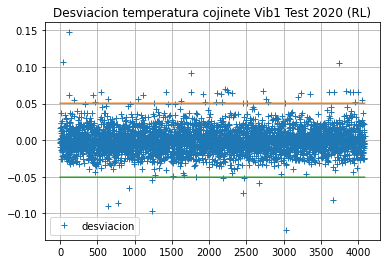

In [24]:
# Representation of the points within the range of 3 times train_2020's STD
plt.plot(desviacion_test_2020, label='desviacion', marker='+', linestyle='None')
plt.plot([3*std]*len(desviacion_test_2020))
plt.plot([-3*std]*len(desviacion_test_2020))
plt.title('Desviacion temperatura cojinete Vib1 Test 2020 (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In [25]:
# Compute the point percentage in the range of 3*STD_train_2020
som=0
for i in range(len(desviacion_test_2020)):
    if (abs(desviacion_test_2020[i])-3*std)>0:
        som+=1
print('Test 2020 :',som)
print('Total 2020 :',len(desviacion_test_2020))
print('% 2020 :',som/len(desviacion_test_2020)*100, '\n')

Test 2020 : 54
Total 2020 : 4087
% 2020 : 1.3212625397602153 


### Histograms plots

Freedman–Diaconis number of bins: 183


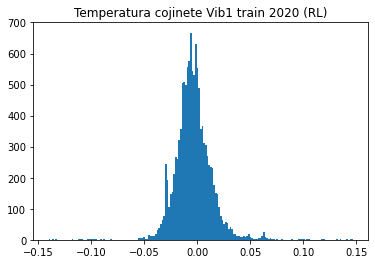

Freedman–Diaconis number of bins: 118


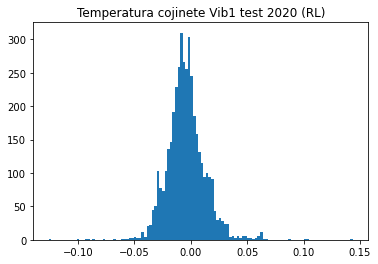

In [26]:
# histograma de error de training
q25, q75 = np.percentile(error_train_2020, [25, 75])
bin_width = 2 * (q75 - q25) * len(error_train_2020) ** (-1/3)
n_bins_train = round((error_train_2020.max() - error_train_2020.min()) / bin_width)
print("Freedman–Diaconis number of bins:", n_bins_train)
plt.hist(error_train_2020[:], bins=n_bins_train);
plt.title('Temperatura cojinete Vib1 train 2020 (RL)')
plt.show()

q25, q75 = np.percentile(error_test_2020, [25, 75])
bin_width = 2 * (q75 - q25) * len(error_test_2020) ** (-1/3)
n_bins_train2 = round((error_test_2020.max() - error_test_2020.min()) / bin_width)
print("Freedman–Diaconis number of bins:", n_bins_train2)
plt.hist(error_test_2020[:], bins=n_bins_train2);
plt.title('Temperatura cojinete Vib1 test 2020 (RL)')
plt.show()

In [27]:
# NaNs' removal
error_train_2020 = error_train_2020[~np.isnan(error_train_2020)]
error_test_2020 = error_test_2020[~np.isnan(error_test_2020)]

# infs' removal
error_train_2020 = error_train_2020[~np.isinf(error_train_2020)]
error_test_2020 = error_test_2020[~np.isinf(error_test_2020)]


<Figure size 432x288 with 0 Axes>

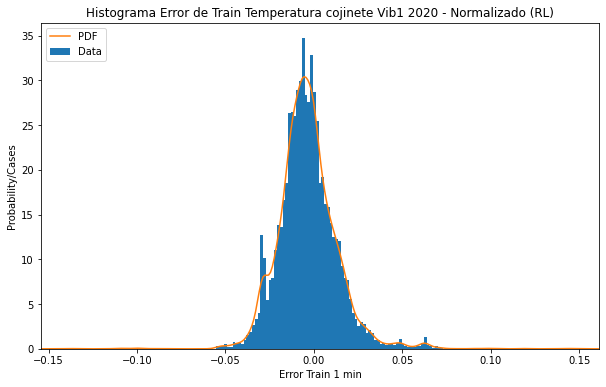

<Figure size 432x288 with 0 Axes>

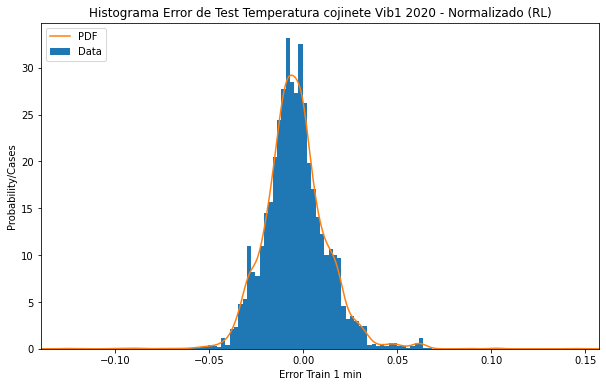

In [28]:
# calculamos pdf del error de traning

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_train_2020[:], density=True, bins=n_bins_train, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_train_2020[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error Train 1 min")
plt.title("Histograma Error de Train Temperatura cojinete Vib1 2020 - Normalizado (RL)");

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_test_2020[:], density=True, bins=n_bins_train2, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_test_2020[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error Train 1 min")
plt.title("Histograma Error de Test Temperatura cojinete Vib1 2020 - Normalizado (RL)");

# TEST PART

### Data imports

In [67]:
# reading csv file
path = 'data/'
archivo1 = 'CC2_BAC1_2020_Load_100.csv'
archivo2 = 'CC2_BAC1_2021_Load_100.csv'
archivo3 = 'CC2_BAC1_2022_Load_100.csv'
archivo11 = 'CC2_BAC1_2020_Load_50.csv'
archivo21 = 'CC2_BAC1_2021_Load_50.csv'
archivo31 = 'CC2_BAC1_2022_Load_50.csv'

df1 = pd.read_csv(path+ archivo1, delimiter = ',', encoding='latin-1')
df2 = pd.read_csv(path+ archivo2, delimiter = ',', encoding='latin-1')
df3 = pd.read_csv(path+ archivo3, delimiter = ',', encoding='latin-1')
df1a = pd.read_csv(path+ archivo11, delimiter = ',', encoding='latin-1')
df2a = pd.read_csv(path+ archivo21, delimiter = ',', encoding='latin-1')
df3a = pd.read_csv(path+ archivo31, delimiter = ',', encoding='latin-1')


df11=df1.dropna() 
df21=df2.dropna() 
df31=df3.dropna() 
df12=df1a.dropna() 
df22=df2a.dropna() 
df32=df3a.dropna() 
df1 = pd.concat([df11, df12]).sort_values('FECHAS', ascending=True) 
df2 = pd.concat([df21, df22]).sort_values('FECHAS', ascending=True) 
df3 = pd.concat([df31, df32]).sort_values('FECHAS', ascending=True) 

# Recuperation of the useful variables
df1_scale = df1.iloc[:, [1,2,3,4,5,6,9,12,13,14]]
datos1 = df1.iloc[:, [1,2,3,4,5,6,9,12,13,14]]#.query("Pot_Turb_Vapor__CC1 >= 10 and Pot_Turb_Vapor__CC2 >= 10 and Pot_Turb_Gas_5__CC2 >= 10 and Pot_Turb_Gas_6__CC2 >= 10")
datos2 = df2.iloc[:, [1,2,3,4,5,6,9,12,13,14]]#.query("Pot_Turb_Vapor__CC1 >= 10 and Pot_Turb_Vapor__CC2 >= 10 and Pot_Turb_Gas_5__CC2 >= 10 and Pot_Turb_Gas_6__CC2 >= 10")
datos3 = df3.iloc[:, [1,2,3,4,5,6,9,12,13,14]]#.query("Pot_Turb_Vapor__CC1 >= 10 and Pot_Turb_Vapor__CC2 >= 10 and Pot_Turb_Gas_5__CC2 >= 10 and Pot_Turb_Gas_6__CC2 >= 10")
  
# Normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df1_scale)
datos1_scaled = scaler.transform(datos1) 
datos2_scaled = scaler.transform(datos2)
datos3_scaled = scaler.transform(datos3) 

X_2020 = datos1_scaled[:,5:7]
y_2020 = datos1_scaled[:,[0]]
X_2021 = datos2_scaled[:,5:7]
y_2021 = datos2_scaled[:,[0]]
X_2022 = datos3_scaled[:,5:7]
y_2022 = datos3_scaled[:,[0]]  


### Predictions visualisation

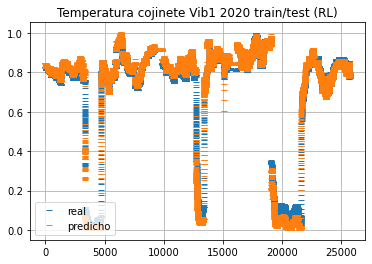

In [68]:
y_prediction_2020 = agent.get_prediction(X_2020)

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_2020), label='real', marker='_', linestyle='None')
plt.plot(np.array(y_prediction_2020), label='predicho', marker='_', linestyle='None')
plt.title('Temperatura cojinete Vib1 2020 train/test (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

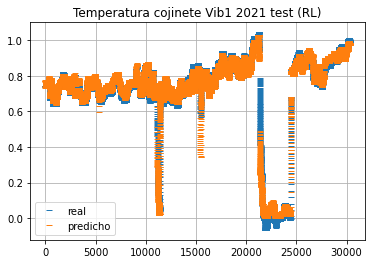

In [69]:
y_prediction_2021 = agent.get_prediction(X_2021)

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_2021), label='real', marker='_', linestyle='None')
plt.plot(np.array(y_prediction_2021), label='predicho', marker='_', linestyle='None')
plt.title('Temperatura cojinete Vib1 2021 test (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

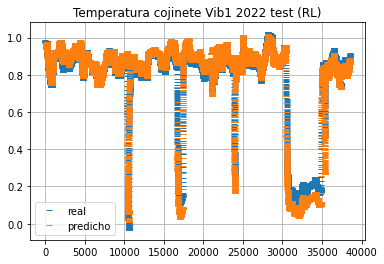

In [70]:
y_prediction_2022 = agent.get_prediction(X_2022) 

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_2022), label='real', marker='_', linestyle='None')
plt.plot(np.array(y_prediction_2022), label='predicho', marker='_', linestyle='None')
plt.title('Temperatura cojinete Vib1 2022 test (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

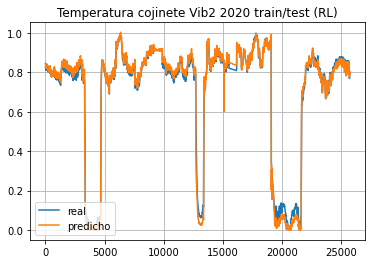

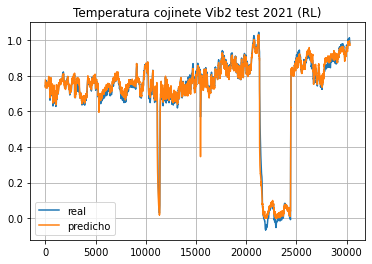

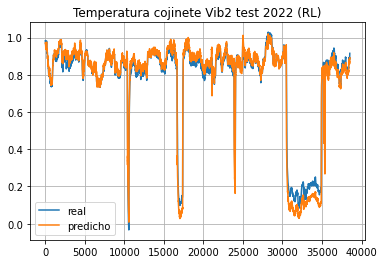

In [71]:
fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_2020), label='real')
plt.plot(np.array(y_prediction_2020), label='predicho')
plt.title('Temperatura cojinete Vib2 2020 train/test (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_2021), label='real')
plt.plot(np.array(y_prediction_2021), label='predicho')
plt.title('Temperatura cojinete Vib2 test 2021 (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

fig, ax = plt.subplots()  # Tamaño figura

plt.plot(np.array(y_2022), label='real')
plt.plot(np.array(y_prediction_2022), label='predicho')
plt.title('Temperatura cojinete Vib2 test 2022 (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

### STD/RMSE computation

Mean 2020:  -7.768698e-05
Mean 2021:  -0.0032782853
Mean 2022:  0.0010403726
Std 2020 :  0.026124345
Std 2021 :  0.025664005
Std 2022 :  0.03841673
RMSE 2020 0.026124459
RMSE 2021 0.02587254
RMSE 2022 0.03843081


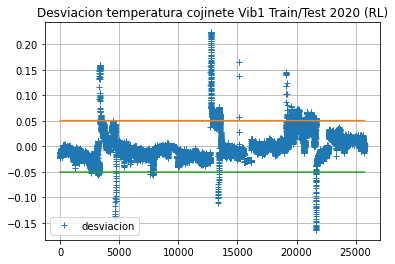

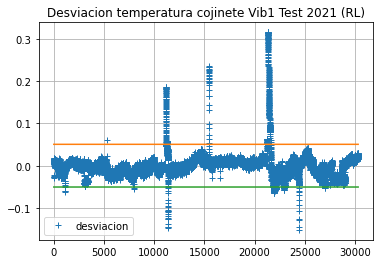

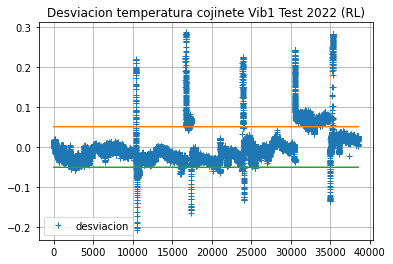

In [72]:
# error computation
error_2020 = []
for i in range(len(y_2020)):
    x=y_2020[i]-y_prediction_2020[i]
    error_2020.append(x.numpy())

error_2021 = []
for i in range(len(y_2021)):
    x=y_2021[i]-y_prediction_2021[i]
    error_2021.append(x.numpy())

error_2022 = []
for i in range(len(y_2022)):
    x=y_2022[i]-y_prediction_2022[i]
    error_2022.append(x.numpy())

error_2020 = np.array(error_2020)
error_2021 = np.array(error_2021)
error_2022 = np.array(error_2022)


# Mean computation
mean_2020 = error_2020.mean()
print("Mean 2020: ", mean_2020)
mean_2021 = error_2021.mean()
print("Mean 2021: ", mean_2021)
mean_2022 = error_2022.mean()
print("Mean 2022: ", mean_2022)


# SDT computation
std_2020 = error_2020.std()
print("Std 2020 : ", std_2020)
std_2021 = error_2021.std()
print("Std 2021 : ", std_2021)
std_2022 = error_2022.std()
print("Std 2022 : ", std_2022)

# RMSE computation
print('RMSE 2020', math.sqrt(reduce_mean(square(error_2020))).numpy())
print('RMSE 2021', math.sqrt(reduce_mean(square(error_2021))).numpy())
print('RMSE 2022', math.sqrt(reduce_mean(square(error_2022))).numpy())

# Representation of the points within the range of 3 times STD_2020
desviacion_2020 = error_2020 -mean_2020
desviacion_2021 = error_2021 -mean_2021
desviacion_2022 = error_2022 -mean_2022

plt.plot(desviacion_2020, label='desviacion', marker='+', linestyle='None')
plt.plot([3*std]*len(desviacion_2020))
plt.plot([-3*std]*len(desviacion_2020))
plt.title('Desviacion temperatura cojinete Vib1 Train/Test 2020 (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

plt.plot(desviacion_2021, label='desviacion', marker='+', linestyle='None')
plt.plot([3*std]*len(desviacion_2021))
plt.plot([-3*std]*len(desviacion_2021))
plt.title('Desviacion temperatura cojinete Vib1 Test 2021 (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

plt.plot(desviacion_2022, label='desviacion', marker='+', linestyle='None')
plt.plot([3*std]*len(desviacion_2022))
plt.plot([-3*std]*len(desviacion_2022))
plt.title('Desviacion temperatura cojinete Vib1 Test 2022 (RL)')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

In [35]:
# Compute the point percentage in the range of 3*STD_2020
som=0
for i in range(len(desviacion_2020)):
    if (abs(desviacion_2020[i])-3*std)>0:
        som+=1
print('2020 :',som)
print('Total 2020 :',len(desviacion_2020))
print('% 2020 :',som/len(desviacion_2020)*100)

som=0
for i in range(len(desviacion_2021)):
    if (abs(desviacion_2021[i])-3*std)>0:
        som+=1
print('2021 :',som)
print('Total 2021 :',len(desviacion_2021))
print('% 2021 :',som/len(desviacion_2021)*100)

som=0
for i in range(len(desviacion_2022)):
    if (abs(desviacion_2022[i])-3*std)>0:
        som+=1
print('2022 :',som)
print('Total 2022 :',len(desviacion_2022))
print('% 2022 :',som/len(desviacion_2022)*100)

2020 : 167
Total 2020 : 15756
% 2020 : 1.0599136836760599
2021 : 120
Total 2021 : 24530
% 2021 : 0.48919690175295555
2022 : 169
Total 2022 : 28131
% 2022 : 0.6007607266005475


### Histograms plots

Freedman–Diaconis number of bins: 221


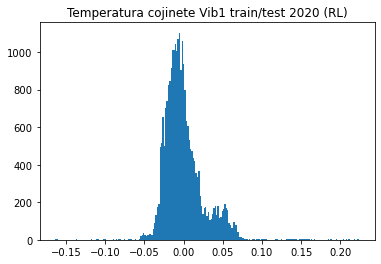

Freedman–Diaconis number of bins: 322


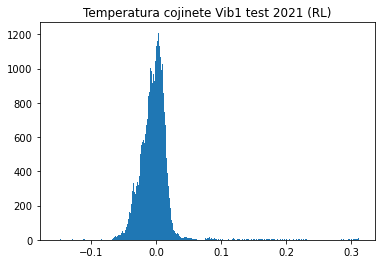

Freedman–Diaconis number of bins: 322


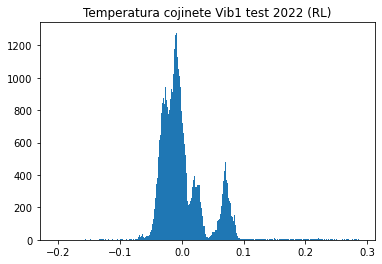

In [73]:
# histograma de error de training
q25, q75 = np.percentile(error_2020, [25, 75])
bin_width = 2 * (q75 - q25) * len(error_2020) ** (-1/3)
n_bins_train = round((error_2020.max() - error_2020.min()) / bin_width)
print("Freedman–Diaconis number of bins:", n_bins_train)
plt.hist(error_2020[:], bins=n_bins_train);
plt.title('Temperatura cojinete Vib1 train/test 2020 (RL)')
plt.show()

q25, q75 = np.percentile(error_2021, [25, 75])
bin_width = 2 * (q75 - q25) * len(error_2021) ** (-1/3)
n_bins_train2 = round((error_2021.max() - error_2021.min()) / bin_width)
print("Freedman–Diaconis number of bins:", n_bins_train2)
plt.hist(error_2021[:], bins=n_bins_train2);
plt.title('Temperatura cojinete Vib1 test 2021 (RL)')
plt.show()

q25, q75 = np.percentile(error_2022, [25, 75])
bin_width = 2 * (q75 - q25) * len(error_2022) ** (-1/3)
n_bins_train3 = round((error_2022.max() - error_2022.min()) / bin_width)
print("Freedman–Diaconis number of bins:", n_bins_train2)
plt.hist(error_2022[:], bins=n_bins_train2);
plt.title('Temperatura cojinete Vib1 test 2022 (RL)')
plt.show()

In [74]:
# NaNs' removal
error_2020 = error_2020[~np.isnan(error_2020)]
error_2021 = error_2021[~np.isnan(error_2021)]
error_2022 = error_2022[~np.isnan(error_2022)]

# infs' removal
error_2020 = error_2020[~np.isinf(error_2020)]
error_2021 = error_2021[~np.isinf(error_2021)]
error_2022 = error_2022[~np.isinf(error_2022)]

<Figure size 432x288 with 0 Axes>

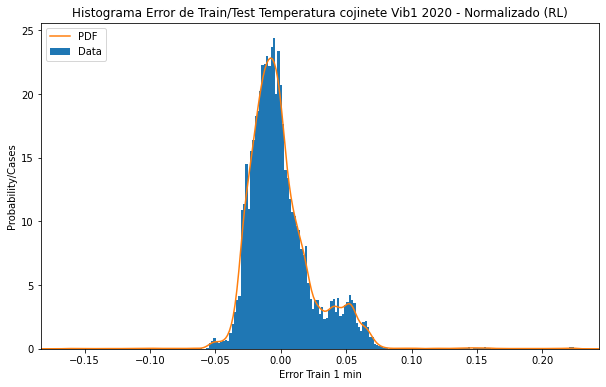

<Figure size 432x288 with 0 Axes>

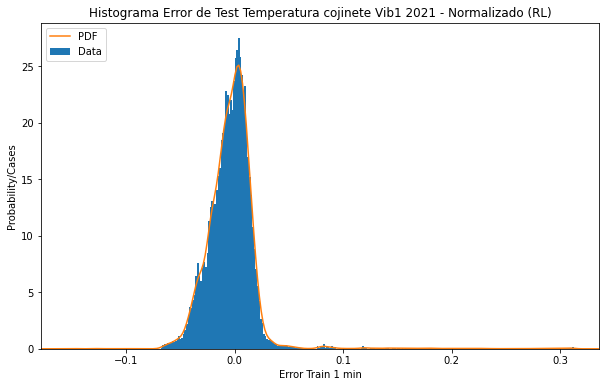

<Figure size 432x288 with 0 Axes>

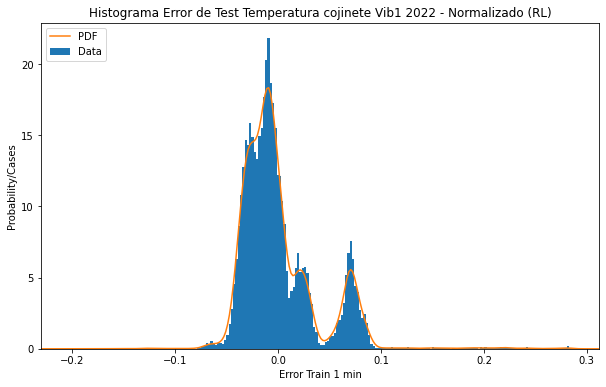

In [75]:
# calculamos pdf del error de traning

import scipy.stats as st

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_2020[:], density=True, bins=n_bins_train, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_2020[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error Train 1 min")
plt.title("Histograma Error de Train/Test Temperatura cojinete Vib1 2020 - Normalizado (RL)");

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_2021[:], density=True, bins=n_bins_train2, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_2021[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error Train 1 min")
plt.title("Histograma Error de Test Temperatura cojinete Vib1 2021 - Normalizado (RL)");

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_2022[:], density=True, bins=n_bins_train3, label="Data")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_2022[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error Train 1 min")
plt.title("Histograma Error de Test Temperatura cojinete Vib1 2022 - Normalizado (RL)");

In [76]:
# Denormalization of real data y_test Year 1
#y_real_2020 = datos1.iloc[:,0]
y_real_dn_2020 = datos1_scaled.copy()  # Creation of a new dataframe containing test dataset for adding normalized prediction
y_real_dn_2020 = scaler.inverse_transform(y_real_dn_2020)

# Denormalization of predicted data y_test
y_test_dn_2020 = datos1_scaled.copy()  # Creation of a new dataframe containing test dataset for adding normalized prediction
y_test_dn_2020[:,0]= np.array(y_prediction_2020).T
y_test_dn_2020 = scaler.inverse_transform(y_test_dn_2020)

In [77]:
# Normalization features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df1_scale)
datos1_scaled = scaler.transform(datos1) 
datos2_scaled = scaler.transform(datos2)
datos3_scaled = scaler.transform(datos3) 

X_2020 = datos1_scaled[:,5:7]
y_2020 = datos1_scaled[:,[0]]
X_2021 = datos2_scaled[:,5:7]
y_2021 = datos2_scaled[:,[0]]
X_2022 = datos3_scaled[:,5:7]
y_2022 = datos3_scaled[:,[0]] 

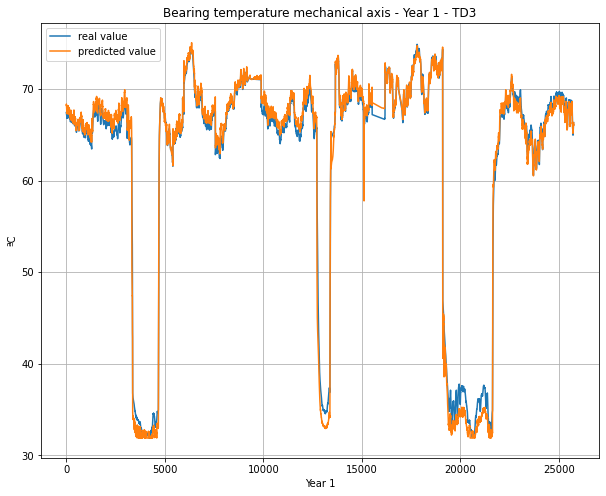

In [78]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(y_real_dn_2020[:,0], label='real value')
plt.plot(y_test_dn_2020[:,0], label='predicted value')
plt.title('Bearing temperature mechanical axis - Year 1 - TD3')
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('Year 1')
plt.ylabel('ªC')
plt.show()


In [79]:
# Denormalization of real data y_test Year 2
#y_real_2020 = datos1.iloc[:,0]
y_real_dn_2021 = datos2_scaled.copy()  # Creation of a new dataframe containing test dataset for adding normalized prediction
y_real_dn_2021 = scaler.inverse_transform(y_real_dn_2021)

# Denormalization of predicted data y_test
y_test_dn_2021 = datos2_scaled.copy()  # Creation of a new dataframe containing test dataset for adding normalized prediction
y_test_dn_2021[:,0]= np.array(y_prediction_2021).T
y_test_dn_2021 = scaler.inverse_transform(y_test_dn_2021)

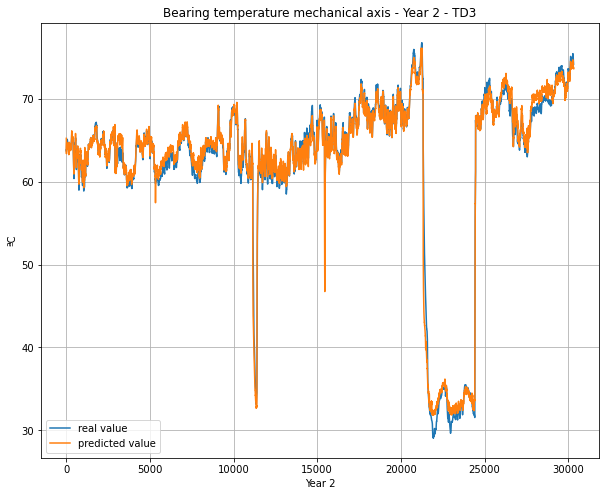

In [80]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(y_real_dn_2021[:,0], label='real value')
plt.plot(y_test_dn_2021[:,0], label='predicted value')
plt.title('Bearing temperature mechanical axis - Year 2 - TD3')
plt.grid(True)
plt.legend(loc='lower left')
plt.xlabel('Year 2')
plt.ylabel('ªC')
plt.show()

In [81]:
# Denormalization of real data y_test Year 2
#y_real_2020 = datos1.iloc[:,0]
y_real_dn_2022 = datos3_scaled.copy()  # Creation of a new dataframe containing test dataset for adding normalized prediction
y_real_dn_2022 = scaler.inverse_transform(y_real_dn_2022)

# Denormalization of predicted data y_test
y_test_dn_2022 = datos3_scaled.copy()  # Creation of a new dataframe containing test dataset for adding normalized prediction
y_test_dn_2022[:,0]= np.array(y_prediction_2022).T
y_test_dn_2022 = scaler.inverse_transform(y_test_dn_2022)

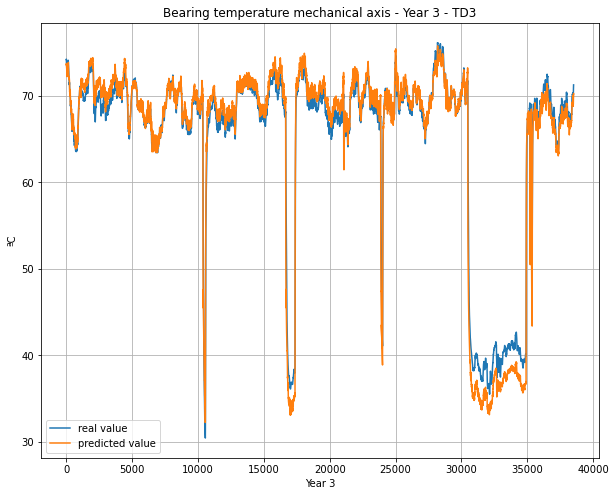

In [82]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 8))

plt.plot(y_real_dn_2022[:,0], label='real value')
plt.plot(y_test_dn_2022[:,0], label='predicted value')
plt.title('Bearing temperature mechanical axis - Year 3 - TD3')
plt.grid(True)
plt.legend(loc='lower left')
plt.xlabel('Year 3')
plt.ylabel('ªC')
plt.show()

<Figure size 432x288 with 0 Axes>

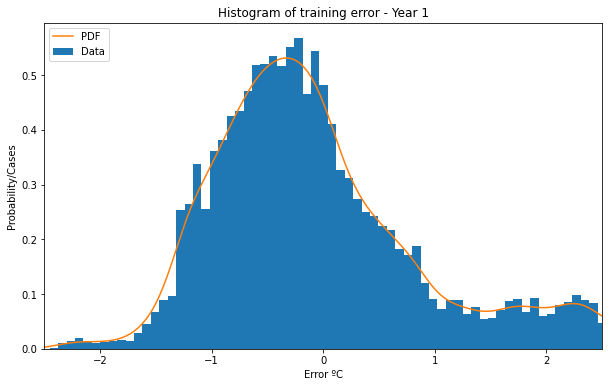

In [83]:
# calculamos pdf del error de traning

import scipy.stats as st

error_2020=y_real_dn_2020[:,0]-y_test_dn_2020[:,0]

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_2020.T, density=True, bins=n_bins_train, label="Data")
mn, mx = plt.xlim(-2.5,2.5)
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_2020[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error ºC")
plt.title("Histogram of training error - Year 1");

<Figure size 432x288 with 0 Axes>

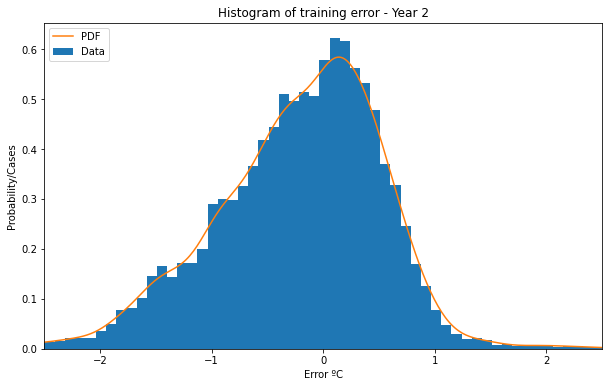

In [84]:
# calculamos pdf del error de traning

import scipy.stats as st

error_2021=y_real_dn_2021[:,0]-y_test_dn_2021[:,0]

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_2021.T, density=True, bins=n_bins_train, label="Data")
mn, mx = plt.xlim(-2.5,2.5)
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_2021[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error ºC")
plt.title("Histogram of training error - Year 2");

<Figure size 432x288 with 0 Axes>

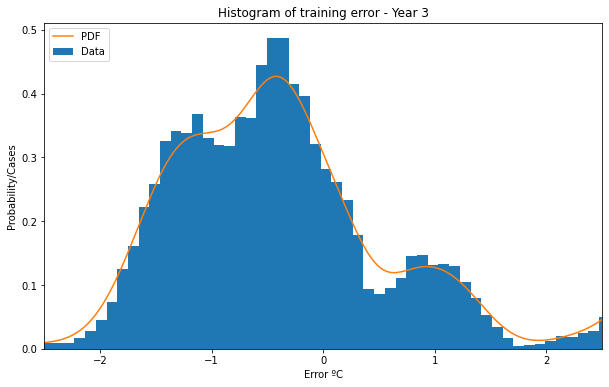

In [85]:
# calculamos pdf del error de traning

import scipy.stats as st

error_2022=y_real_dn_2022[:,0]-y_test_dn_2022[:,0]

plt.figure()
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 6))  # Tamaño figura

plt.hist(error_2022.T, density=True, bins=n_bins_train, label="Data")
mn, mx = plt.xlim(-2.5,2.5)
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(error_2022[:])
plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.legend(loc="upper left")
plt.ylabel("Probability/Cases")
plt.xlabel("Error ºC")
plt.title("Histogram of training error - Year 3");

In [86]:
# Test error
error_2020=y_real_dn_2020[:,0]-y_test_dn_2020[:,0]

error_2021=y_real_dn_2021[:,0]-y_test_dn_2021[:,0]

error_2022=y_real_dn_2022[:,0]-y_test_dn_2022[:,0]

In [87]:
# Mean computation
#mean_train = error_train_ent_2020.mean()
#print("Mean train : ", mean_train)

#mean_test = error_test_ent_2020.mean()
#print("Mean test : ", mean_test)

mean_2020 = error_2020.mean()
print("Mean 2020 : ", mean_2020)

mean_2021 = error_2021.mean()
print("Mean 2021 : ", mean_2021)

mean_2022 = error_2022.mean()
print("Mean 2022 : ", mean_2022)

# STD computation
#std_train = error_train_ent_2020.std()
#print("Std train : ", std_train)

#std_test = error_train_ent_2020.std()
#print("Std test : ", std_test)

std_2020 = error_2020.std()
print("Std 2020 : ", std_2020)

std_2021 = error_2021.std()
print("Std 2021 : ", std_2021)

std_2022 = error_2022.std()
print("Std 2022 : ", std_2022)

Mean 2020 :  -0.003341491075792207
Mean 2021 :  -0.14100719402607753
Mean 2022 :  0.044749046069317455
Std 2020 :  1.1236728440341717
Std 2021 :  1.1038725138404786
Std 2022 :  1.652398627345611


In [88]:
# RMSE computation
#print('RMSE train', math.sqrt(reduce_mean(square(error_train_ent_2020))).numpy())
#print('RMSE test', math.sqrt(reduce_mean(square(error_test_ent_2020))).numpy())
print('RMSE 2020', math.sqrt(reduce_mean(square(error_2020))).numpy())
print('RMSE 2021', math.sqrt(reduce_mean(square(error_2021))).numpy())
print('RMSE 2022', math.sqrt(reduce_mean(square(error_2022))).numpy())

RMSE 2020 1.123677812356573
RMSE 2021 1.1128421072100054
RMSE 2022 1.6530044466902605


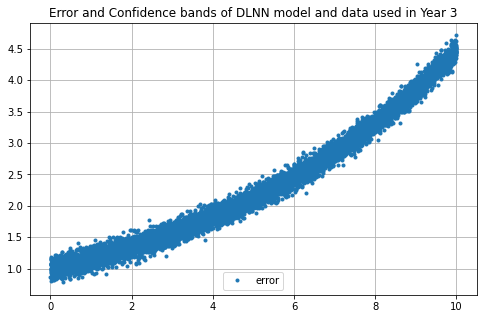

In [90]:
#Creacion anomalia
# SEñal anomalia exponencial

alpha=0.15
A=1
X_exp = np.arange(0, 10, 0.001)
Y_exp = A*(np.exp(alpha*X_exp)) + 0.09*np.random.randn(10000)
#data_caca = np.hstack((X_caca.reshape(10000,1),Y_caca.reshape(10000,1)))


fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(X_exp,Y_exp, label='error', marker='.', linestyle='None')
#plt.plot(error_2022[0:10000], marker='.', linestyle='None')

plt.title('Error and Confidence bands of DLNN model and data used in Year 3')

plt.grid(True)
plt.legend(loc='lower center')
plt.show() 

In [91]:
# Señal creciente lineal
X_recta = np.linspace(0, 1, 10000)
Y_recta = (0.9*X_recta) + 0.09*np.random.randn(10000)

# Señal ruido plano
X_plano = np.linspace(0, 1, 18518)
Y_plano =  0.08*np.random.randn(18518)

In [92]:
# Añadimos las señales simuladas 
anomalia=np.append(Y_plano, Y_recta)
anomalia=np.append(anomalia, Y_exp)

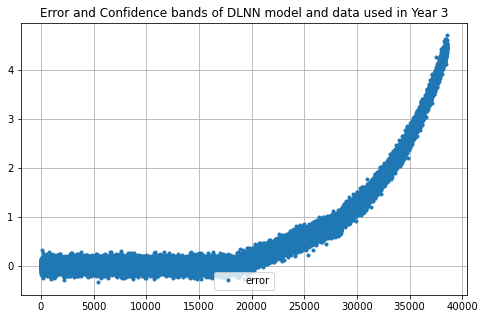

In [94]:
X_anom=X_exp = np.arange(0, 38518, 1)
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(X_anom,anomalia, label='error', marker='.', linestyle='None')
#plt.plot(error_2022[0:10000], marker='.', linestyle='None')

plt.title('Error and Confidence bands of DLNN model and data used in Year 3')

plt.grid(True)
plt.legend(loc='lower center')
plt.show() 

In [95]:
print(" size",y_real_dn_2022[:,0].shape)

 size (38518,)


In [119]:
# Superponemos a la señal real Year 3
real=np.copy(y_test_dn_2022[:,0])
simulado=np.copy(real)

simulado=np.add(simulado,anomalia)

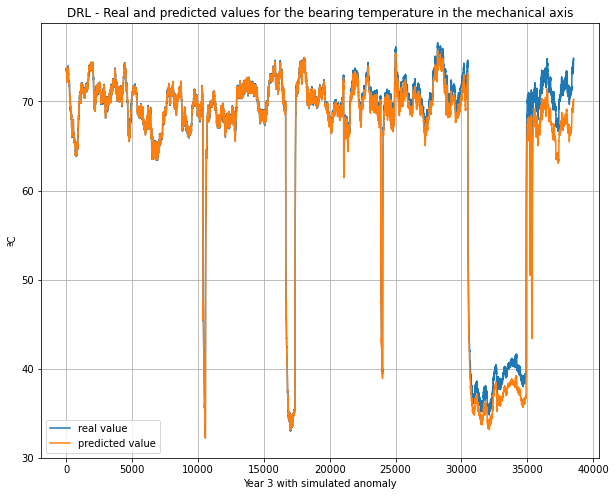

In [120]:
fig, ax = plt.subplots(figsize=(10,8))



plt.plot(simulado,  label='real value')
plt.plot(real,label='predicted value')
#plt.plot(y_real_dn_2022[:,0], label='real value')
#plt.plot(y_test_dn_2022[:,0], label='predicted value')
#plt.plot([3*std_2020]*len(error_2020))
#plt.plot([-3*std_2020]*len(error_2020))
plt.title('DRL - Real and predicted values for the bearing temperature in the mechanical axis')
plt.xlabel('Year 3 with simulated anomaly')
plt.ylabel('ªC')
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

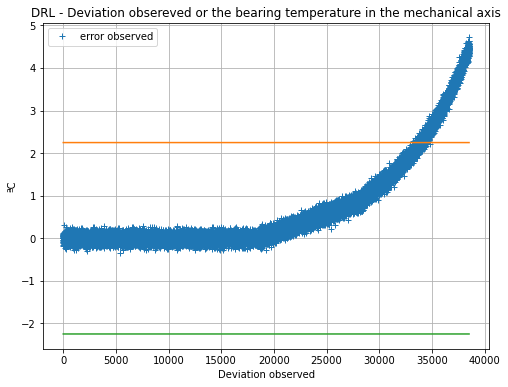

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(simulado-real, label='error observed', marker='+', linestyle='None')
plt.plot([2*std_2020]*len(simulado-real))
plt.plot([-2*std_2020]*len(simulado-real))
plt.title('DRL - Deviation obsereved or the bearing temperature in the mechanical axis')
#plt.ylim(-3,6)
plt.xlabel('Deviation observed')
plt.ylabel('ªC')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

In [122]:
# Riesgo
riesgo_DRL= simulado-real -2*std_2020
#riesgo_DRL[riesgo_DLNN <= 3*std_2020] =0

riesgo_DRL[riesgo_DRL <= 0] =0

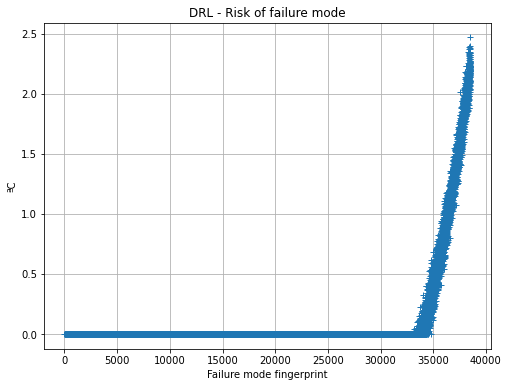

In [123]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(riesgo_DRL, label='riesgo', marker='+', linestyle='None')
#plt.plot([3*std_2020]*len(simulado-real))
#plt.plot([-3*std_2020]*len(simulado-real))
plt.title('DRL - Risk of failure mode')
plt.grid(True)
plt.xlabel('Failure mode fingerprint')
plt.ylabel('ªC')
#plt.legend(loc='lower left')
plt.show()

In [127]:
# Riesgo de DLNN
riesgo_DLNN = np.fromfile("riesgo_DLNN.dat", dtype=float)

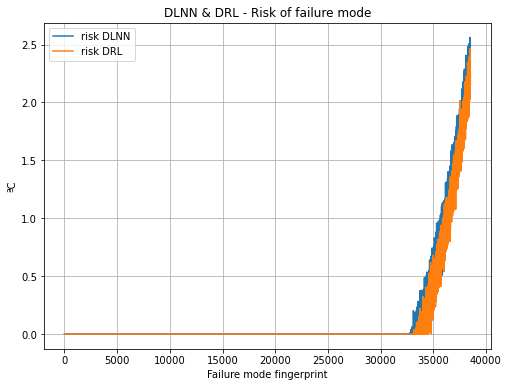

In [128]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(riesgo_DLNN, label='risk DLNN')
plt.plot(riesgo_DRL, label='risk DRL')
#plt.plot([3*std_2020]*len(simulado-real))
#plt.plot([-3*std_2020]*len(simulado-real))
plt.title('DLNN & DRL - Risk of failure mode')
plt.grid(True)
plt.xlabel('Failure mode fingerprint')
plt.ylabel('ªC')
plt.legend(loc='upper left')
plt.show()

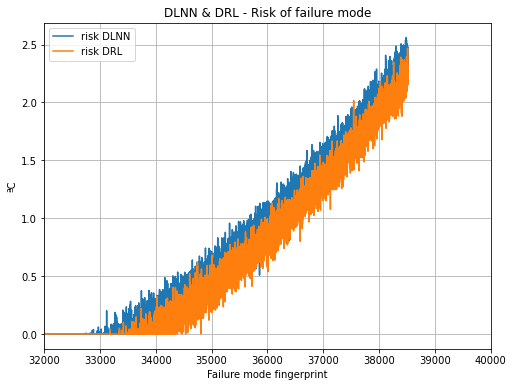

In [129]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(riesgo_DLNN, label='risk DLNN')
plt.plot(riesgo_DRL, label='risk DRL')
#plt.plot([3*std_2020]*len(simulado-real))
#plt.plot([-3*std_2020]*len(simulado-real))
plt.title('DLNN & DRL - Risk of failure mode')
plt.grid(True)
plt.xlim(32000,40000)
plt.xlabel('Failure mode fingerprint')
plt.ylabel('ªC')
plt.legend(loc='upper left')
plt.show()